# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.3509834200361945 -2.793101944868054
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [65]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    # tf.nn.sigmoid(1+0.99*(Qs_logits)) --> tf.ones_like(Qs_logits) if Qs_logits >> 1
    #Qs_label = targetQs[1:]
    # g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
    #                                                                  labels=tf.ones_like(Qs_logits)))
    g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(
                                                                         tf.nn.sigmoid(targetQs[1:]), 
                                                                         shape=[-1, 1])))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * tf.nn.sigmoid(targetQs))
    #g_lossP = tf.reduce_mean(neg_log_prob_actions * targetQs)
    g_lossP = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = g_lossQ + g_lossP
    #g_loss = g_lossP

    return actions_logits, Qs_logits, g_loss, d_loss, g_lossQ, g_lossP

In [66]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [67]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.g_lossP = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [68]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(59, 4) actions:(59,)
action size:2


In [69]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [70]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [71]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [88]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/400 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_lossQ, g_lossP, g_loss, d_loss, _, _ = sess.run([model.g_lossQ, model.g_lossP, 
                                                           model.g_loss, model.d_loss, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'glossQ:{:.4f}'.format(g_lossQ),
              'glossP:{:.4f}'.format(g_lossP),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 400:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:9.0000 glossQ:0.6931 glossP:-0.0032 gloss:0.6899 dloss:0.6916
Episode:1 meanR:23.0000 glossQ:0.6936 glossP:0.0423 gloss:0.7359 dloss:0.7184
Episode:2 meanR:25.6667 glossQ:0.6934 glossP:0.0431 gloss:0.7366 dloss:0.7198
Episode:3 meanR:25.5000 glossQ:0.6927 glossP:0.0657 gloss:0.7583 dloss:0.7347
Episode:4 meanR:24.2000 glossQ:0.6927 glossP:0.0573 gloss:0.7500 dloss:0.7299
Episode:5 meanR:22.6667 glossQ:0.6921 glossP:0.0713 gloss:0.7634 dloss:0.7388
Episode:6 meanR:20.8571 glossQ:0.6915 glossP:0.0773 gloss:0.7687 dloss:0.7414
Episode:7 meanR:19.6250 glossQ:0.6912 glossP:0.0718 gloss:0.7630 dloss:0.7371
Episode:8 meanR:18.4444 glossQ:0.6922 glossP:0.0333 gloss:0.7254 dloss:0.7108
Episode:9 meanR:17.6000 glossQ:0.6928 glossP:-0.0095 gloss:0.6833 dloss:0.6816
Episode:10 meanR:16.7273 glossQ:0.6918 glossP:-0.0608 gloss:0.6310 dloss:0.6444
Episode:11 meanR:16.0833 glossQ:0.6893 glossP:-0.1005 gloss:0.5889 dloss:0.6162
Episode:12 meanR:15.6154 glossQ:0.6839 glossP:-0.1561 gloss

Episode:102 meanR:36.4900 glossQ:0.3947 glossP:-1.2823 gloss:-0.8876 dloss:0.3356
Episode:103 meanR:36.5600 glossQ:0.3834 glossP:-1.3193 gloss:-0.9360 dloss:0.2913
Episode:104 meanR:36.6300 glossQ:0.3973 glossP:-1.2751 gloss:-0.8778 dloss:0.2665
Episode:105 meanR:36.6800 glossQ:0.3898 glossP:-1.2995 gloss:-0.9097 dloss:0.2361
Episode:106 meanR:36.7900 glossQ:0.3822 glossP:-1.3268 gloss:-0.9446 dloss:0.2382
Episode:107 meanR:36.9500 glossQ:0.3762 glossP:-1.3466 gloss:-0.9704 dloss:0.2652
Episode:108 meanR:37.0300 glossQ:0.3648 glossP:-1.3856 gloss:-1.0209 dloss:0.2127
Episode:109 meanR:37.1300 glossQ:0.3633 glossP:-1.3934 gloss:-1.0301 dloss:0.2272
Episode:110 meanR:37.2400 glossQ:0.3465 glossP:-1.4531 gloss:-1.1066 dloss:0.2178
Episode:111 meanR:37.3400 glossQ:0.3216 glossP:-1.5395 gloss:-1.2179 dloss:0.2109
Episode:112 meanR:37.3900 glossQ:0.3125 glossP:-1.5715 gloss:-1.2590 dloss:0.1872
Episode:113 meanR:37.4600 glossQ:0.2894 glossP:-1.6594 gloss:-1.3700 dloss:0.1935
Episode:114 mean

Episode:203 meanR:41.7700 glossQ:0.3629 glossP:-1.3904 gloss:-1.0275 dloss:0.6392
Episode:204 meanR:42.7900 glossQ:0.3660 glossP:-1.3816 gloss:-1.0156 dloss:0.7676
Episode:205 meanR:44.6400 glossQ:0.3676 glossP:-1.3771 gloss:-1.0095 dloss:1.1507
Episode:206 meanR:47.6000 glossQ:0.3731 glossP:-1.3589 gloss:-0.9858 dloss:1.6910
Episode:207 meanR:49.3200 glossQ:0.3781 glossP:-1.3454 gloss:-0.9673 dloss:1.1051
Episode:208 meanR:53.4700 glossQ:0.3944 glossP:-1.2928 gloss:-0.8984 dloss:2.1642
Episode:209 meanR:58.2700 glossQ:0.4030 glossP:-1.2632 gloss:-0.8602 dloss:2.4335
Episode:210 meanR:62.9000 glossQ:0.4190 glossP:-1.2194 gloss:-0.8005 dloss:2.2873
Episode:211 meanR:64.5900 glossQ:0.4286 glossP:-1.1951 gloss:-0.7665 dloss:0.9803
Episode:212 meanR:66.0500 glossQ:0.4366 glossP:-1.1804 gloss:-0.7438 dloss:0.8631
Episode:213 meanR:66.9100 glossQ:0.4346 glossP:-1.1956 gloss:-0.7610 dloss:0.6202
Episode:214 meanR:67.2500 glossQ:0.4228 glossP:-1.2360 gloss:-0.8132 dloss:0.3820
Episode:215 mean

Episode:303 meanR:71.7700 glossQ:0.4266 glossP:-1.1995 gloss:-0.7729 dloss:2.3306
Episode:304 meanR:75.4900 glossQ:0.4340 glossP:-1.1909 gloss:-0.7569 dloss:2.3232
Episode:305 meanR:78.4400 glossQ:0.4291 glossP:-1.2078 gloss:-0.7788 dloss:2.3545
Episode:306 meanR:78.0600 glossQ:0.4372 glossP:-1.1852 gloss:-0.7480 dloss:1.3733
Episode:307 meanR:78.3600 glossQ:0.4530 glossP:-1.1342 gloss:-0.6812 dloss:1.1284
Episode:308 meanR:76.0100 glossQ:0.4628 glossP:-1.0992 gloss:-0.6364 dloss:0.9805
Episode:309 meanR:71.5100 glossQ:0.4485 glossP:-1.1454 gloss:-0.6969 dloss:0.3986
Episode:310 meanR:67.2200 glossQ:0.4597 glossP:-1.1069 gloss:-0.6472 dloss:0.4151
Episode:311 meanR:65.7500 glossQ:0.4520 glossP:-1.1295 gloss:-0.6774 dloss:0.3679
Episode:312 meanR:64.6800 glossQ:0.4684 glossP:-1.0709 gloss:-0.6025 dloss:0.4206
Episode:313 meanR:63.9900 glossQ:0.5504 glossP:-0.8099 gloss:-0.2596 dloss:0.3715
Episode:314 meanR:63.8600 glossQ:0.5599 glossP:-0.7785 gloss:-0.2186 dloss:0.3786
Episode:315 mean

Episode:403 meanR:72.7300 glossQ:0.5084 glossP:-0.9402 gloss:-0.4318 dloss:0.4585
Episode:404 meanR:68.1800 glossQ:0.5054 glossP:-0.9503 gloss:-0.4449 dloss:0.3828
Episode:405 meanR:63.5900 glossQ:0.5024 glossP:-0.9597 gloss:-0.4573 dloss:0.3687
Episode:406 meanR:61.1200 glossQ:0.4813 glossP:-1.0351 gloss:-0.5539 dloss:0.3324
Episode:407 meanR:59.1500 glossQ:0.4860 glossP:-1.0215 gloss:-0.5355 dloss:0.3347
Episode:408 meanR:57.6400 glossQ:0.4612 glossP:-1.1178 gloss:-0.6566 dloss:0.3877
Episode:409 meanR:57.5800 glossQ:0.4560 glossP:-1.1374 gloss:-0.6814 dloss:0.3796
Episode:410 meanR:57.5800 glossQ:0.4562 glossP:-1.1247 gloss:-0.6685 dloss:0.4129
Episode:411 meanR:57.3700 glossQ:0.4528 glossP:-1.1199 gloss:-0.6671 dloss:0.2722
Episode:412 meanR:56.9300 glossQ:0.4096 glossP:-1.2560 gloss:-0.8464 dloss:0.2113
Episode:413 meanR:56.8600 glossQ:0.4833 glossP:-1.0234 gloss:-0.5401 dloss:0.3094
Episode:414 meanR:56.7600 glossQ:0.4754 glossP:-1.0455 gloss:-0.5701 dloss:0.2961
Episode:415 mean

Episode:507 meanR:65.1100 glossQ:0.5097 glossP:-0.9342 gloss:-0.4245 dloss:1.2968
Episode:508 meanR:67.6100 glossQ:0.5387 glossP:-0.8513 gloss:-0.3127 dloss:1.1718
Episode:509 meanR:68.5100 glossQ:0.5289 glossP:-0.8851 gloss:-0.3562 dloss:0.6804
Episode:510 meanR:69.0900 glossQ:0.5362 glossP:-0.8594 gloss:-0.3232 dloss:0.6018
Episode:511 meanR:69.7600 glossQ:0.5358 glossP:-0.8597 gloss:-0.3239 dloss:0.5269
Episode:512 meanR:69.8200 glossQ:0.4938 glossP:-0.9899 gloss:-0.4961 dloss:0.2796
Episode:513 meanR:69.6400 glossQ:0.4219 glossP:-1.2165 gloss:-0.7946 dloss:0.2213
Episode:514 meanR:69.5100 glossQ:0.4040 glossP:-1.2747 gloss:-0.8708 dloss:0.2206
Episode:515 meanR:69.3800 glossQ:0.4863 glossP:-1.0139 gloss:-0.5276 dloss:0.2846
Episode:516 meanR:69.5000 glossQ:0.5165 glossP:-0.9213 gloss:-0.4048 dloss:0.4303
Episode:517 meanR:69.9400 glossQ:0.5439 glossP:-0.8338 gloss:-0.2899 dloss:0.5335
Episode:518 meanR:70.3600 glossQ:0.5538 glossP:-0.8022 gloss:-0.2484 dloss:0.5275
Episode:519 mean

Episode:611 meanR:82.1200 glossQ:0.4818 glossP:-1.0331 gloss:-0.5513 dloss:0.3244
Episode:612 meanR:82.8600 glossQ:0.5216 glossP:-0.9021 gloss:-0.3805 dloss:0.5478
Episode:613 meanR:83.4600 glossQ:0.4942 glossP:-0.9924 gloss:-0.4982 dloss:0.4771
Episode:614 meanR:84.3200 glossQ:0.5256 glossP:-0.8880 gloss:-0.3625 dloss:0.5681
Episode:615 meanR:84.5800 glossQ:0.5153 glossP:-0.9228 gloss:-0.4074 dloss:0.3980
Episode:616 meanR:84.3000 glossQ:0.5063 glossP:-0.9567 gloss:-0.4504 dloss:0.3408
Episode:617 meanR:84.1300 glossQ:0.4960 glossP:-0.9864 gloss:-0.4905 dloss:0.4882
Episode:618 meanR:83.7400 glossQ:0.5289 glossP:-0.8766 gloss:-0.3478 dloss:0.4131
Episode:619 meanR:83.5700 glossQ:0.4791 glossP:-1.0450 gloss:-0.5659 dloss:0.4837
Episode:620 meanR:83.2600 glossQ:0.5311 glossP:-0.8689 gloss:-0.3377 dloss:0.4153
Episode:621 meanR:83.5500 glossQ:0.5118 glossP:-0.9337 gloss:-0.4219 dloss:0.5842
Episode:622 meanR:83.1900 glossQ:0.5275 glossP:-0.8848 gloss:-0.3573 dloss:0.4505
Episode:623 mean

Episode:718 meanR:52.8300 glossQ:0.4273 glossP:-1.2000 gloss:-0.7727 dloss:0.4987
Episode:719 meanR:54.0000 glossQ:0.4348 glossP:-1.1810 gloss:-0.7462 dloss:0.9667
Episode:720 meanR:54.2200 glossQ:0.3970 glossP:-1.2978 gloss:-0.9009 dloss:0.4794
Episode:721 meanR:53.5600 glossQ:0.3894 glossP:-1.3226 gloss:-0.9332 dloss:0.3107
Episode:722 meanR:53.2400 glossQ:0.3783 glossP:-1.3580 gloss:-0.9797 dloss:0.2741
Episode:723 meanR:53.1300 glossQ:0.3384 glossP:-1.4880 gloss:-1.1496 dloss:0.1866
Episode:724 meanR:52.9400 glossQ:0.3491 glossP:-1.4530 gloss:-1.1039 dloss:0.2057
Episode:725 meanR:52.7100 glossQ:0.3767 glossP:-1.3695 gloss:-0.9928 dloss:0.2898
Episode:726 meanR:53.4800 glossQ:0.3791 glossP:-1.3606 gloss:-0.9815 dloss:0.7928
Episode:727 meanR:53.4300 glossQ:0.1911 glossP:-2.2551 gloss:-2.0640 dloss:0.1455
Episode:728 meanR:54.0100 glossQ:0.3735 glossP:-1.3792 gloss:-1.0057 dloss:0.5501
Episode:729 meanR:54.4100 glossQ:0.3921 glossP:-1.3154 gloss:-0.9232 dloss:0.4576
Episode:730 mean

Episode:818 meanR:62.7900 glossQ:0.4604 glossP:-1.0965 gloss:-0.6361 dloss:0.4459
Episode:819 meanR:61.1700 glossQ:0.4107 glossP:-1.2739 gloss:-0.8632 dloss:0.2753
Episode:820 meanR:60.7400 glossQ:0.4061 glossP:-1.2818 gloss:-0.8757 dloss:0.2825
Episode:821 meanR:60.5900 glossQ:0.3713 glossP:-1.4215 gloss:-1.0502 dloss:0.2391
Episode:822 meanR:60.6000 glossQ:0.4056 glossP:-1.2782 gloss:-0.8726 dloss:0.2872
Episode:823 meanR:60.8300 glossQ:0.4276 glossP:-1.1999 gloss:-0.7723 dloss:0.3235
Episode:824 meanR:61.4100 glossQ:0.4376 glossP:-1.1635 gloss:-0.7259 dloss:0.4846
Episode:825 meanR:62.9000 glossQ:0.4568 glossP:-1.0973 gloss:-0.6405 dloss:0.9005
Episode:826 meanR:63.0600 glossQ:0.4225 glossP:-1.2181 gloss:-0.7956 dloss:0.8242
Episode:827 meanR:63.6300 glossQ:0.4127 glossP:-1.2611 gloss:-0.8483 dloss:0.4643
Episode:828 meanR:63.2500 glossQ:0.4060 glossP:-1.2971 gloss:-0.8911 dloss:0.3724
Episode:829 meanR:64.0300 glossQ:0.4679 glossP:-1.0811 gloss:-0.6132 dloss:0.7630
Episode:830 mean

Episode:920 meanR:122.9800 glossQ:0.5044 glossP:-0.9567 gloss:-0.4523 dloss:0.3954
Episode:921 meanR:123.3500 glossQ:0.4951 glossP:-0.9886 gloss:-0.4935 dloss:0.4261
Episode:922 meanR:123.6400 glossQ:0.4590 glossP:-1.1275 gloss:-0.6684 dloss:0.4371
Episode:923 meanR:123.5000 glossQ:0.4051 glossP:-1.3476 gloss:-0.9425 dloss:0.2829
Episode:924 meanR:123.2000 glossQ:0.4366 glossP:-1.1894 gloss:-0.7528 dloss:0.3642
Episode:925 meanR:121.7600 glossQ:0.4370 glossP:-1.1798 gloss:-0.7428 dloss:0.3289
Episode:926 meanR:120.4800 glossQ:0.4066 glossP:-1.2850 gloss:-0.8785 dloss:0.2609
Episode:927 meanR:120.0600 glossQ:0.4014 glossP:-1.2978 gloss:-0.8964 dloss:0.2710
Episode:928 meanR:119.9800 glossQ:0.4289 glossP:-1.2182 gloss:-0.7893 dloss:0.3388
Episode:929 meanR:118.8200 glossQ:0.3837 glossP:-1.3661 gloss:-0.9824 dloss:0.2810
Episode:930 meanR:115.5900 glossQ:0.2842 glossP:-1.9192 gloss:-1.6350 dloss:0.2265
Episode:931 meanR:115.2500 glossQ:0.4517 glossP:-1.1396 gloss:-0.6879 dloss:0.7172
Epis

Episode:1021 meanR:76.4900 glossQ:0.5227 glossP:-0.8943 gloss:-0.3715 dloss:0.7123
Episode:1022 meanR:76.9500 glossQ:0.5286 glossP:-0.8784 gloss:-0.3498 dloss:0.5791
Episode:1023 meanR:80.2500 glossQ:0.5377 glossP:-0.8461 gloss:-0.3084 dloss:1.3361
Episode:1024 meanR:81.4800 glossQ:0.5702 glossP:-0.7389 gloss:-0.1687 dloss:0.7444
Episode:1025 meanR:82.8500 glossQ:0.5845 glossP:-0.6884 gloss:-0.1039 dloss:0.7486
Episode:1026 meanR:83.2500 glossQ:0.5139 glossP:-0.9239 gloss:-0.4100 dloss:0.4445
Episode:1027 meanR:83.9200 glossQ:0.5311 glossP:-0.8673 gloss:-0.3362 dloss:0.5423
Episode:1028 meanR:84.3900 glossQ:0.5457 glossP:-0.8213 gloss:-0.2757 dloss:0.5218
Episode:1029 meanR:84.7900 glossQ:0.5350 glossP:-0.8588 gloss:-0.3238 dloss:0.4672
Episode:1030 meanR:85.2100 glossQ:0.5445 glossP:-0.8299 gloss:-0.2854 dloss:0.4437
Episode:1031 meanR:84.5200 glossQ:0.5520 glossP:-0.8047 gloss:-0.2527 dloss:0.4501
Episode:1032 meanR:84.3300 glossQ:0.4840 glossP:-1.0243 gloss:-0.5402 dloss:0.2912
Epis

Episode:1121 meanR:91.1200 glossQ:0.6046 glossP:-0.6114 gloss:-0.0068 dloss:0.5429
Episode:1122 meanR:90.8900 glossQ:0.6020 glossP:-0.6199 gloss:-0.0179 dloss:0.5358
Episode:1123 meanR:88.0300 glossQ:0.5863 glossP:-0.6818 gloss:-0.0954 dloss:0.4905
Episode:1124 meanR:87.2900 glossQ:0.6099 glossP:-0.5907 gloss:0.0192 dloss:0.5638
Episode:1125 meanR:86.2400 glossQ:0.5725 glossP:-0.7317 gloss:-0.1592 dloss:0.4914
Episode:1126 meanR:86.8400 glossQ:0.5646 glossP:-0.7534 gloss:-0.1888 dloss:0.6328
Episode:1127 meanR:87.0700 glossQ:0.5296 glossP:-0.8707 gloss:-0.3411 dloss:0.6275
Episode:1128 meanR:86.9000 glossQ:0.5475 glossP:-0.8180 gloss:-0.2706 dloss:0.4744
Episode:1129 meanR:86.9100 glossQ:0.5694 glossP:-0.7432 gloss:-0.1738 dloss:0.4877
Episode:1130 meanR:86.5000 glossQ:0.5155 glossP:-0.9274 gloss:-0.4120 dloss:0.3087
Episode:1131 meanR:86.0700 glossQ:0.4861 glossP:-1.0184 gloss:-0.5322 dloss:0.2832
Episode:1132 meanR:85.9600 glossQ:0.4115 glossP:-1.2560 gloss:-0.8446 dloss:0.2273
Episo

Episode:1223 meanR:102.3000 glossQ:0.4761 glossP:-1.0391 gloss:-0.5630 dloss:0.6873
Episode:1224 meanR:101.6200 glossQ:0.3348 glossP:-1.5297 gloss:-1.1949 dloss:0.2510
Episode:1225 meanR:101.1100 glossQ:0.2957 glossP:-1.6808 gloss:-1.3850 dloss:0.1999
Episode:1226 meanR:100.0300 glossQ:0.2393 glossP:-1.9156 gloss:-1.6763 dloss:0.1731
Episode:1227 meanR:99.0600 glossQ:0.2286 glossP:-1.9823 gloss:-1.7537 dloss:0.1976
Episode:1228 meanR:98.5000 glossQ:0.1976 glossP:-2.1329 gloss:-1.9352 dloss:0.1529
Episode:1229 meanR:97.9500 glossQ:0.1995 glossP:-2.1409 gloss:-1.9415 dloss:0.1709
Episode:1230 meanR:97.8800 glossQ:0.1787 glossP:-2.2653 gloss:-2.0866 dloss:0.1463
Episode:1231 meanR:97.8400 glossQ:0.1961 glossP:-2.1383 gloss:-1.9422 dloss:0.1590
Episode:1232 meanR:97.8800 glossQ:0.2212 glossP:-2.0089 gloss:-1.7877 dloss:0.1761
Episode:1233 meanR:97.9600 glossQ:0.2701 glossP:-1.7851 gloss:-1.5150 dloss:0.2002
Episode:1234 meanR:98.3200 glossQ:0.3404 glossP:-1.5229 gloss:-1.1825 dloss:0.3853


Episode:1322 meanR:139.7000 glossQ:0.6501 glossP:-0.3941 gloss:0.2560 dloss:0.6457
Episode:1323 meanR:139.9600 glossQ:0.6626 glossP:-0.3041 gloss:0.3585 dloss:0.6825
Episode:1324 meanR:140.7900 glossQ:0.6565 glossP:-0.3612 gloss:0.2953 dloss:0.6161
Episode:1325 meanR:141.6300 glossQ:0.6609 glossP:-0.3204 gloss:0.3404 dloss:0.6184
Episode:1326 meanR:142.6900 glossQ:0.6643 glossP:-0.2949 gloss:0.3694 dloss:0.6434
Episode:1327 meanR:143.5300 glossQ:0.6629 glossP:-0.3271 gloss:0.3357 dloss:0.6138
Episode:1328 meanR:144.6500 glossQ:0.6672 glossP:-0.2743 gloss:0.3929 dloss:0.6496
Episode:1329 meanR:145.8300 glossQ:0.6695 glossP:-0.2466 gloss:0.4229 dloss:0.6616
Episode:1330 meanR:147.0900 glossQ:0.6660 glossP:-0.2913 gloss:0.3747 dloss:0.6589
Episode:1331 meanR:148.2900 glossQ:0.6681 glossP:-0.2574 gloss:0.4107 dloss:0.6624
Episode:1332 meanR:149.4500 glossQ:0.6655 glossP:-0.3044 gloss:0.3611 dloss:0.6510
Episode:1333 meanR:150.9100 glossQ:0.6682 glossP:-0.2847 gloss:0.3835 dloss:0.6860
Epis

Episode:1426 meanR:84.1900 glossQ:0.3855 glossP:-1.3763 gloss:-0.9908 dloss:0.3139
Episode:1427 meanR:83.6000 glossQ:0.4167 glossP:-1.2675 gloss:-0.8508 dloss:0.3587
Episode:1428 meanR:83.1700 glossQ:0.4862 glossP:-1.0202 gloss:-0.5340 dloss:0.5097
Episode:1429 meanR:83.1900 glossQ:0.5617 glossP:-0.7661 gloss:-0.2043 dloss:0.6623
Episode:1430 meanR:86.8200 glossQ:0.5220 glossP:-0.9213 gloss:-0.3993 dloss:1.9004
Episode:1431 meanR:86.9000 glossQ:0.3815 glossP:-1.3844 gloss:-1.0029 dloss:0.8504
Episode:1432 meanR:86.9600 glossQ:0.3594 glossP:-1.4987 gloss:-1.1393 dloss:0.8798
Episode:1433 meanR:85.8100 glossQ:0.3568 glossP:-1.4582 gloss:-1.1014 dloss:0.3838
Episode:1434 meanR:84.5700 glossQ:0.3760 glossP:-1.3954 gloss:-1.0195 dloss:0.3460
Episode:1435 meanR:83.2800 glossQ:0.3487 glossP:-1.4924 gloss:-1.1438 dloss:0.2545
Episode:1436 meanR:81.9400 glossQ:0.3219 glossP:-1.5857 gloss:-1.2637 dloss:0.2280
Episode:1437 meanR:80.1200 glossQ:0.3028 glossP:-1.6539 gloss:-1.3511 dloss:0.1966
Epis

Episode:1525 meanR:71.2900 glossQ:0.3903 glossP:-1.3330 gloss:-0.9428 dloss:0.2304
Episode:1526 meanR:71.1700 glossQ:0.4065 glossP:-1.2817 gloss:-0.8752 dloss:0.2635
Episode:1527 meanR:70.9400 glossQ:0.3792 glossP:-1.3719 gloss:-0.9927 dloss:0.2422
Episode:1528 meanR:70.2800 glossQ:0.3656 glossP:-1.4170 gloss:-1.0514 dloss:0.2130
Episode:1529 meanR:69.0900 glossQ:0.3450 glossP:-1.4874 gloss:-1.1424 dloss:0.2079
Episode:1530 meanR:64.2600 glossQ:0.3261 glossP:-1.5577 gloss:-1.2316 dloss:0.2145
Episode:1531 meanR:63.0000 glossQ:0.3047 glossP:-1.6421 gloss:-1.3373 dloss:0.2011
Episode:1532 meanR:61.7700 glossQ:0.2815 glossP:-1.7403 gloss:-1.4588 dloss:0.1921
Episode:1533 meanR:61.3700 glossQ:0.2550 glossP:-1.8864 gloss:-1.6314 dloss:0.1612
Episode:1534 meanR:61.0700 glossQ:0.2484 glossP:-1.9134 gloss:-1.6649 dloss:0.1781
Episode:1535 meanR:60.9200 glossQ:0.2408 glossP:-1.9801 gloss:-1.7393 dloss:0.1660
Episode:1536 meanR:61.5200 glossQ:0.3940 glossP:-1.3586 gloss:-0.9646 dloss:0.5517
Epis

Episode:1624 meanR:60.2500 glossQ:0.5205 glossP:-0.9097 gloss:-0.3892 dloss:0.6502
Episode:1625 meanR:63.3500 glossQ:0.5488 glossP:-0.8184 gloss:-0.2697 dloss:1.2361
Episode:1626 meanR:64.0200 glossQ:0.5323 glossP:-0.8729 gloss:-0.3406 dloss:0.5348
Episode:1627 meanR:64.7500 glossQ:0.5445 glossP:-0.8323 gloss:-0.2878 dloss:0.5439
Episode:1628 meanR:65.4800 glossQ:0.5452 glossP:-0.8341 gloss:-0.2889 dloss:0.5292
Episode:1629 meanR:66.1300 glossQ:0.5492 glossP:-0.8206 gloss:-0.2715 dloss:0.5058
Episode:1630 meanR:66.8000 glossQ:0.5552 glossP:-0.8036 gloss:-0.2483 dloss:0.5185
Episode:1631 meanR:67.3700 glossQ:0.5493 glossP:-0.8238 gloss:-0.2746 dloss:0.4825
Episode:1632 meanR:67.8700 glossQ:0.5530 glossP:-0.8120 gloss:-0.2590 dloss:0.4600
Episode:1633 meanR:68.4900 glossQ:0.5557 glossP:-0.8043 gloss:-0.2486 dloss:0.4814
Episode:1634 meanR:69.0900 glossQ:0.5557 glossP:-0.8053 gloss:-0.2496 dloss:0.4843
Episode:1635 meanR:69.6300 glossQ:0.5558 glossP:-0.8051 gloss:-0.2494 dloss:0.4610
Epis

Episode:1723 meanR:126.2000 glossQ:0.6911 glossP:-0.0021 gloss:0.6890 dloss:0.7031
Episode:1724 meanR:127.0000 glossQ:0.6867 glossP:-0.0937 gloss:0.5930 dloss:0.7091
Episode:1725 meanR:124.9800 glossQ:0.6912 glossP:-0.0247 gloss:0.6664 dloss:0.6958
Episode:1726 meanR:125.6800 glossQ:0.6873 glossP:-0.1218 gloss:0.5655 dloss:0.6882
Episode:1727 meanR:126.3900 glossQ:0.6833 glossP:-0.1046 gloss:0.5787 dloss:0.6949
Episode:1728 meanR:126.9300 glossQ:0.6820 glossP:-0.1156 gloss:0.5664 dloss:0.6854
Episode:1729 meanR:127.1400 glossQ:0.6884 glossP:-0.1463 gloss:0.5421 dloss:0.6502
Episode:1730 meanR:127.7900 glossQ:0.6762 glossP:-0.2444 gloss:0.4318 dloss:0.6720
Episode:1731 meanR:128.1100 glossQ:0.6833 glossP:-0.1983 gloss:0.4850 dloss:0.6388
Episode:1732 meanR:128.7300 glossQ:0.6778 glossP:-0.2275 gloss:0.4504 dloss:0.6561
Episode:1733 meanR:129.2300 glossQ:0.6764 glossP:-0.2511 gloss:0.4253 dloss:0.6438
Episode:1734 meanR:129.6800 glossQ:0.6720 glossP:-0.2845 gloss:0.3875 dloss:0.6336
Epis

Episode:1822 meanR:146.7200 glossQ:0.6371 glossP:-0.4804 gloss:0.1567 dloss:0.7561
Episode:1823 meanR:150.4100 glossQ:0.6364 glossP:-0.4801 gloss:0.1563 dloss:1.2861
Episode:1824 meanR:149.9400 glossQ:0.6414 glossP:-0.4536 gloss:0.1879 dloss:0.6907
Episode:1825 meanR:149.4800 glossQ:0.6158 glossP:-0.5447 gloss:0.0711 dloss:0.5521
Episode:1826 meanR:148.5200 glossQ:0.6165 glossP:-0.5315 gloss:0.0850 dloss:0.5278
Episode:1827 meanR:147.2400 glossQ:0.5904 glossP:-0.6315 gloss:-0.0412 dloss:0.4503
Episode:1828 meanR:146.2400 glossQ:0.5908 glossP:-0.6341 gloss:-0.0433 dloss:0.4584
Episode:1829 meanR:145.5800 glossQ:0.5793 glossP:-0.6840 gloss:-0.1047 dloss:0.4287
Episode:1830 meanR:144.4700 glossQ:0.5675 glossP:-0.7214 gloss:-0.1539 dloss:0.4294
Episode:1831 meanR:143.5400 glossQ:0.4801 glossP:-1.0232 gloss:-0.5431 dloss:0.2956
Episode:1832 meanR:142.3700 glossQ:0.4589 glossP:-1.1025 gloss:-0.6436 dloss:0.2825
Episode:1833 meanR:141.2500 glossQ:0.4620 glossP:-1.0922 gloss:-0.6302 dloss:0.28

Episode:1923 meanR:110.4600 glossQ:0.5672 glossP:-0.7386 gloss:-0.1713 dloss:0.5901
Episode:1924 meanR:109.6000 glossQ:0.4954 glossP:-0.9876 gloss:-0.4922 dloss:0.4846
Episode:1925 meanR:109.2700 glossQ:0.4980 glossP:-0.9796 gloss:-0.4816 dloss:0.3972
Episode:1926 meanR:109.0700 glossQ:0.4642 glossP:-1.0898 gloss:-0.6255 dloss:0.3780
Episode:1927 meanR:109.3900 glossQ:0.4539 glossP:-1.1157 gloss:-0.6618 dloss:0.4692
Episode:1928 meanR:109.0900 glossQ:0.4031 glossP:-1.3085 gloss:-0.9054 dloss:0.2501
Episode:1929 meanR:109.3700 glossQ:0.5161 glossP:-0.9194 gloss:-0.4034 dloss:0.4601
Episode:1930 meanR:109.8100 glossQ:0.5336 glossP:-0.9022 gloss:-0.3685 dloss:0.5473
Episode:1931 meanR:110.5500 glossQ:0.5059 glossP:-0.9855 gloss:-0.4796 dloss:0.5489
Episode:1932 meanR:111.1500 glossQ:0.4951 glossP:-1.0404 gloss:-0.5453 dloss:0.4973
Episode:1933 meanR:111.1700 glossQ:0.3689 glossP:-1.4471 gloss:-1.0781 dloss:0.2387
Episode:1934 meanR:111.6700 glossQ:0.4588 glossP:-1.1545 gloss:-0.6957 dloss

Episode:2022 meanR:147.9000 glossQ:0.6672 glossP:-0.3052 gloss:0.3620 dloss:0.7059
Episode:2023 meanR:149.0300 glossQ:0.6652 glossP:-0.3241 gloss:0.3412 dloss:0.7509
Episode:2024 meanR:150.5100 glossQ:0.6647 glossP:-0.3288 gloss:0.3359 dloss:0.7535
Episode:2025 meanR:151.5600 glossQ:0.6550 glossP:-0.3757 gloss:0.2793 dloss:0.6780
Episode:2026 meanR:152.7700 glossQ:0.6573 glossP:-0.3746 gloss:0.2827 dloss:0.6931
Episode:2027 meanR:153.7100 glossQ:0.6677 glossP:-0.3002 gloss:0.3675 dloss:0.6863
Episode:2028 meanR:155.5500 glossQ:0.6752 glossP:-0.2523 gloss:0.4230 dloss:0.7148
Episode:2029 meanR:156.7700 glossQ:0.6624 glossP:-0.3403 gloss:0.3221 dloss:0.7158
Episode:2030 meanR:158.0300 glossQ:0.6617 glossP:-0.3506 gloss:0.3111 dloss:0.7451
Episode:2031 meanR:158.4800 glossQ:0.6642 glossP:-0.3215 gloss:0.3427 dloss:0.6513
Episode:2032 meanR:160.1000 glossQ:0.6623 glossP:-0.3499 gloss:0.3124 dloss:0.7728
Episode:2033 meanR:161.4000 glossQ:0.6615 glossP:-0.3433 gloss:0.3183 dloss:0.6620
Epis

Episode:2124 meanR:173.8400 glossQ:0.5299 glossP:-0.8444 gloss:-0.3144 dloss:0.3566
Episode:2125 meanR:172.4300 glossQ:0.6809 glossP:-0.1884 gloss:0.4925 dloss:0.5776
Episode:2126 meanR:170.8900 glossQ:0.6717 glossP:-0.2731 gloss:0.3986 dloss:0.5262
Episode:2127 meanR:169.3500 glossQ:0.6788 glossP:-0.1995 gloss:0.4793 dloss:0.5757
Episode:2128 meanR:167.4800 glossQ:0.6544 glossP:-0.3660 gloss:0.2884 dloss:0.4905
Episode:2129 meanR:166.0800 glossQ:0.5316 glossP:-0.8301 gloss:-0.2985 dloss:0.4430
Episode:2130 meanR:164.0900 glossQ:0.3061 glossP:-1.7228 gloss:-1.4167 dloss:0.2025
Episode:2131 meanR:162.8900 glossQ:0.2974 glossP:-1.8072 gloss:-1.5098 dloss:0.2148
Episode:2132 meanR:160.6900 glossQ:0.6289 glossP:-0.5159 gloss:0.1130 dloss:0.4273
Episode:2133 meanR:159.4000 glossQ:0.5814 glossP:-0.6839 gloss:-0.1025 dloss:0.3670
Episode:2134 meanR:158.0800 glossQ:0.5807 glossP:-0.6927 gloss:-0.1120 dloss:0.3630
Episode:2135 meanR:157.1300 glossQ:0.5588 glossP:-0.7683 gloss:-0.2095 dloss:0.34

Episode:2223 meanR:176.0600 glossQ:0.6538 glossP:-0.1277 gloss:0.5261 dloss:0.7633
Episode:2224 meanR:177.1500 glossQ:0.6698 glossP:-0.2248 gloss:0.4450 dloss:0.6732
Episode:2225 meanR:177.6000 glossQ:0.6585 glossP:-0.2990 gloss:0.3595 dloss:0.5937
Episode:2226 meanR:177.9400 glossQ:0.6088 glossP:-0.5047 gloss:0.1041 dloss:0.5396
Episode:2227 meanR:177.9900 glossQ:0.6149 glossP:-0.5717 gloss:0.0432 dloss:0.4354
Episode:2228 meanR:178.0200 glossQ:0.5638 glossP:-0.7276 gloss:-0.1638 dloss:0.3961
Episode:2229 meanR:177.6800 glossQ:0.5430 glossP:-0.7896 gloss:-0.2466 dloss:0.3855
Episode:2230 meanR:177.7000 glossQ:0.5698 glossP:-0.7227 gloss:-0.1529 dloss:0.3966
Episode:2231 meanR:177.9400 glossQ:0.5456 glossP:-0.8182 gloss:-0.2725 dloss:0.4670
Episode:2232 meanR:178.0000 glossQ:0.6225 glossP:-0.5688 gloss:0.0536 dloss:0.4289
Episode:2233 meanR:178.3300 glossQ:0.5956 glossP:-0.6093 gloss:-0.0137 dloss:0.5275
Episode:2234 meanR:178.7100 glossQ:0.6207 glossP:-0.4990 gloss:0.1217 dloss:0.5321

Episode:2323 meanR:208.2900 glossQ:0.5930 glossP:0.6351 gloss:1.2282 dloss:0.6060
Episode:2324 meanR:212.0400 glossQ:0.5670 glossP:0.7335 gloss:1.3005 dloss:0.0413
Episode:2325 meanR:216.4900 glossQ:0.6472 glossP:0.4198 gloss:1.0670 dloss:0.2863
Episode:2326 meanR:217.6000 glossQ:0.6600 glossP:0.2316 gloss:0.8915 dloss:0.7662
Episode:2327 meanR:222.4700 glossQ:0.4549 glossP:1.1014 gloss:1.5563 dloss:-0.1976
Episode:2328 meanR:227.3500 glossQ:0.4487 glossP:1.1214 gloss:1.5701 dloss:-0.2165
Episode:2329 meanR:229.9100 glossQ:0.3572 glossP:1.4613 gloss:1.8185 dloss:0.8435
Episode:2330 meanR:231.1600 glossQ:0.4961 glossP:0.9690 gloss:1.4651 dloss:1.1535
Episode:2331 meanR:232.3900 glossQ:0.6428 glossP:0.3275 gloss:0.9702 dloss:0.8001
Episode:2332 meanR:233.7700 glossQ:0.6430 glossP:0.3312 gloss:0.9743 dloss:0.8029
Episode:2333 meanR:235.0300 glossQ:0.6388 glossP:0.3668 gloss:1.0055 dloss:0.7910
Episode:2334 meanR:236.2000 glossQ:0.5142 glossP:0.9048 gloss:1.4190 dloss:1.0162
Episode:2335 m

Episode:2429 meanR:141.9300 glossQ:0.4630 glossP:-1.1193 gloss:-0.6563 dloss:0.5138
Episode:2430 meanR:140.7100 glossQ:0.2216 glossP:-2.1006 gloss:-1.8791 dloss:0.1822
Episode:2431 meanR:139.3400 glossQ:0.2966 glossP:-1.8018 gloss:-1.5053 dloss:0.2394
Episode:2432 meanR:137.9700 glossQ:0.2753 glossP:-1.8594 gloss:-1.5841 dloss:0.2157
Episode:2433 meanR:137.2800 glossQ:0.4645 glossP:-1.1036 gloss:-0.6391 dloss:0.6074
Episode:2434 meanR:135.9900 glossQ:0.3695 glossP:-1.4624 gloss:-1.0930 dloss:0.3354
Episode:2435 meanR:133.4500 glossQ:0.3726 glossP:-1.4587 gloss:-1.0861 dloss:0.4135
Episode:2436 meanR:131.2700 glossQ:0.3697 glossP:-1.4597 gloss:-1.0901 dloss:0.4072
Episode:2437 meanR:131.2600 glossQ:0.4577 glossP:-1.1141 gloss:-0.6564 dloss:0.7156
Episode:2438 meanR:128.2300 glossQ:0.5275 glossP:-0.8685 gloss:-0.3410 dloss:0.8990
Episode:2439 meanR:126.9600 glossQ:0.3036 glossP:-1.7397 gloss:-1.4360 dloss:0.2741
Episode:2440 meanR:123.4800 glossQ:0.3178 glossP:-1.7043 gloss:-1.3865 dloss

Episode:2532 meanR:111.3200 glossQ:0.4323 glossP:-1.2879 gloss:-0.8556 dloss:0.3299
Episode:2533 meanR:110.8200 glossQ:0.4694 glossP:-1.1761 gloss:-0.7067 dloss:0.4230
Episode:2534 meanR:110.9800 glossQ:0.4873 glossP:-1.1011 gloss:-0.6137 dloss:0.4325
Episode:2535 meanR:111.3400 glossQ:0.5516 glossP:-0.8392 gloss:-0.2876 dloss:0.5568
Episode:2536 meanR:113.3100 glossQ:0.6635 glossP:-0.2758 gloss:0.3877 dloss:0.8138
Episode:2537 meanR:113.0200 glossQ:0.4501 glossP:-1.1429 gloss:-0.6927 dloss:0.6144
Episode:2538 meanR:111.7100 glossQ:0.3212 glossP:-1.6257 gloss:-1.3044 dloss:0.5065
Episode:2539 meanR:111.8600 glossQ:0.3083 glossP:-1.6798 gloss:-1.3715 dloss:0.3664
Episode:2540 meanR:111.7700 glossQ:0.3765 glossP:-1.4097 gloss:-1.0332 dloss:0.2502
Episode:2541 meanR:110.9000 glossQ:0.3348 glossP:-1.5670 gloss:-1.2322 dloss:0.2193
Episode:2542 meanR:106.0900 glossQ:0.3824 glossP:-1.3972 gloss:-1.0148 dloss:0.2536
Episode:2543 meanR:104.7100 glossQ:0.3378 glossP:-1.5639 gloss:-1.2261 dloss:

Episode:2631 meanR:152.4100 glossQ:0.6435 glossP:-0.4605 gloss:0.1830 dloss:0.5336
Episode:2632 meanR:152.6100 glossQ:0.6193 glossP:-0.5568 gloss:0.0624 dloss:0.4934
Episode:2633 meanR:152.5500 glossQ:0.6085 glossP:-0.6196 gloss:-0.0111 dloss:0.4585
Episode:2634 meanR:152.5300 glossQ:0.6117 glossP:-0.6244 gloss:-0.0126 dloss:0.4681
Episode:2635 meanR:152.0800 glossQ:0.5979 glossP:-0.6724 gloss:-0.0745 dloss:0.4396
Episode:2636 meanR:150.0700 glossQ:0.5935 glossP:-0.6875 gloss:-0.0940 dloss:0.4451
Episode:2637 meanR:149.4500 glossQ:0.5874 glossP:-0.7036 gloss:-0.1163 dloss:0.4249
Episode:2638 meanR:149.3200 glossQ:0.5998 glossP:-0.6571 gloss:-0.0573 dloss:0.4658
Episode:2639 meanR:149.6200 glossQ:0.5963 glossP:-0.6650 gloss:-0.0687 dloss:0.5108
Episode:2640 meanR:150.1900 glossQ:0.5822 glossP:-0.7075 gloss:-0.1253 dloss:0.5218
Episode:2641 meanR:150.9200 glossQ:0.5649 glossP:-0.7562 gloss:-0.1913 dloss:0.5570
Episode:2642 meanR:152.0300 glossQ:0.6006 glossP:-0.6233 gloss:-0.0227 dloss:0

Episode:2737 meanR:73.2800 glossQ:0.4795 glossP:-1.0496 gloss:-0.5700 dloss:0.4634
Episode:2738 meanR:74.0200 glossQ:0.5480 glossP:-0.8182 gloss:-0.2702 dloss:0.6527
Episode:2739 meanR:73.5800 glossQ:0.4079 glossP:-1.4000 gloss:-0.9921 dloss:0.3213
Episode:2740 meanR:72.9000 glossQ:0.1478 glossP:-2.8205 gloss:-2.6727 dloss:0.1523
Episode:2741 meanR:72.4800 glossQ:0.4027 glossP:-1.4395 gloss:-1.0368 dloss:0.4196
Episode:2742 meanR:71.5000 glossQ:0.3886 glossP:-1.3931 gloss:-1.0045 dloss:0.3140
Episode:2743 meanR:70.7900 glossQ:0.2246 glossP:-2.1920 gloss:-1.9674 dloss:0.1721
Episode:2744 meanR:70.1000 glossQ:0.2021 glossP:-2.2755 gloss:-2.0733 dloss:0.1615
Episode:2745 meanR:70.6500 glossQ:0.5053 glossP:-0.9699 gloss:-0.4646 dloss:0.7767
Episode:2746 meanR:69.9300 glossQ:0.1296 glossP:-3.0481 gloss:-2.9185 dloss:0.1488
Episode:2747 meanR:69.9700 glossQ:0.3867 glossP:-1.4081 gloss:-1.0213 dloss:0.4491
Episode:2748 meanR:70.1900 glossQ:0.4386 glossP:-1.1800 gloss:-0.7413 dloss:0.5606
Epis

Episode:2837 meanR:81.6500 glossQ:0.5635 glossP:-0.7740 gloss:-0.2105 dloss:0.6424
Episode:2838 meanR:81.6200 glossQ:0.5653 glossP:-0.7657 gloss:-0.2004 dloss:0.6439
Episode:2839 meanR:82.5400 glossQ:0.5873 glossP:-0.6950 gloss:-0.1077 dloss:0.6294
Episode:2840 meanR:87.4500 glossQ:0.6413 glossP:-0.4304 gloss:0.2109 dloss:1.2296
Episode:2841 meanR:87.2900 glossQ:0.4518 glossP:-1.1606 gloss:-0.7088 dloss:0.3307
Episode:2842 meanR:87.3000 glossQ:0.4532 glossP:-1.1697 gloss:-0.7165 dloss:0.3474
Episode:2843 meanR:92.2000 glossQ:0.6619 glossP:-0.3659 gloss:0.2960 dloss:1.1251
Episode:2844 meanR:93.9500 glossQ:0.6415 glossP:-0.4721 gloss:0.1694 dloss:0.7402
Episode:2845 meanR:93.7900 glossQ:0.6504 glossP:-0.4175 gloss:0.2329 dloss:0.6682
Episode:2846 meanR:95.5900 glossQ:0.6685 glossP:-0.3200 gloss:0.3485 dloss:0.7162
Episode:2847 meanR:99.9900 glossQ:0.6440 glossP:-0.4511 gloss:0.1929 dloss:1.2456
Episode:2848 meanR:100.6200 glossQ:0.6435 glossP:-0.4122 gloss:0.2313 dloss:0.6885
Episode:28

Episode:2938 meanR:272.4900 glossQ:0.6075 glossP:0.5128 gloss:1.1203 dloss:0.9350
Episode:2939 meanR:275.4300 glossQ:0.5664 glossP:0.7040 gloss:1.2704 dloss:0.2692
Episode:2940 meanR:271.6100 glossQ:0.6146 glossP:0.4448 gloss:1.0594 dloss:0.9186
Episode:2941 meanR:273.2900 glossQ:0.5768 glossP:0.6253 gloss:1.2021 dloss:0.8252
Episode:2942 meanR:277.0100 glossQ:0.5698 glossP:0.6870 gloss:1.2568 dloss:0.2957
Episode:2943 meanR:276.3800 glossQ:0.5672 glossP:0.6950 gloss:1.2622 dloss:0.2069
Episode:2944 meanR:276.5600 glossQ:0.5992 glossP:0.5373 gloss:1.1365 dloss:0.7910
Episode:2945 meanR:276.7700 glossQ:0.6075 glossP:0.5206 gloss:1.1281 dloss:0.8643
Episode:2946 meanR:276.1000 glossQ:0.6195 glossP:0.4775 gloss:1.0971 dloss:0.9180
Episode:2947 meanR:272.5900 glossQ:0.6147 glossP:0.4827 gloss:1.0974 dloss:0.8757
Episode:2948 meanR:272.7300 glossQ:0.6446 glossP:0.2780 gloss:0.9226 dloss:0.7824
Episode:2949 meanR:273.4600 glossQ:0.6369 glossP:0.3831 gloss:1.0200 dloss:0.8888
Episode:2950 mea

Episode:3040 meanR:70.4500 glossQ:0.4252 glossP:-1.2293 gloss:-0.8041 dloss:0.4936
Episode:3041 meanR:69.0400 glossQ:0.3949 glossP:-1.3367 gloss:-0.9419 dloss:0.4302
Episode:3042 meanR:65.7300 glossQ:0.4133 glossP:-1.2917 gloss:-0.8783 dloss:0.5112
Episode:3043 meanR:62.0000 glossQ:0.4023 glossP:-1.3244 gloss:-0.9221 dloss:0.4631
Episode:3044 meanR:60.0900 glossQ:0.1585 glossP:-2.5648 gloss:-2.4063 dloss:0.1628
Episode:3045 meanR:58.6000 glossQ:0.1730 glossP:-2.4637 gloss:-2.2907 dloss:0.1709
Episode:3046 meanR:57.4800 glossQ:0.1427 glossP:-3.0854 gloss:-2.9427 dloss:0.1621
Episode:3047 meanR:56.9700 glossQ:0.5101 glossP:-0.9714 gloss:-0.4612 dloss:0.5978
Episode:3048 meanR:55.4200 glossQ:0.1749 glossP:-2.4076 gloss:-2.2327 dloss:0.1636
Episode:3049 meanR:54.4200 glossQ:0.1596 glossP:-2.5635 gloss:-2.4039 dloss:0.1658
Episode:3050 meanR:50.8300 glossQ:0.1771 glossP:-2.3503 gloss:-2.1733 dloss:0.1687
Episode:3051 meanR:47.1600 glossQ:0.2561 glossP:-1.8890 gloss:-1.6329 dloss:0.2229
Epis

Episode:3142 meanR:70.8100 glossQ:0.5196 glossP:-0.9273 gloss:-0.4076 dloss:0.4128
Episode:3143 meanR:70.7000 glossQ:0.5131 glossP:-0.9483 gloss:-0.4352 dloss:0.4258
Episode:3144 meanR:71.1900 glossQ:0.5230 glossP:-0.9235 gloss:-0.4006 dloss:0.4621
Episode:3145 meanR:71.5200 glossQ:0.4682 glossP:-1.0974 gloss:-0.6292 dloss:0.3939
Episode:3146 meanR:71.6000 glossQ:0.3367 glossP:-1.5543 gloss:-1.2176 dloss:0.2265
Episode:3147 meanR:71.0900 glossQ:0.4458 glossP:-1.1722 gloss:-0.7263 dloss:0.3933
Episode:3148 meanR:71.4900 glossQ:0.4719 glossP:-1.0861 gloss:-0.6142 dloss:0.4162
Episode:3149 meanR:71.8900 glossQ:0.4652 glossP:-1.1136 gloss:-0.6484 dloss:0.4224
Episode:3150 meanR:72.3900 glossQ:0.4583 glossP:-1.1356 gloss:-0.6773 dloss:0.4577
Episode:3151 meanR:72.2900 glossQ:0.2129 glossP:-2.1227 gloss:-1.9099 dloss:0.1658
Episode:3152 meanR:71.4000 glossQ:0.2435 glossP:-1.9489 gloss:-1.7055 dloss:0.1995
Episode:3153 meanR:71.2500 glossQ:0.2325 glossP:-1.9769 gloss:-1.7444 dloss:0.1852
Epis

Episode:3246 meanR:56.9300 glossQ:0.4947 glossP:-0.9788 gloss:-0.4842 dloss:0.5957
Episode:3247 meanR:57.1400 glossQ:0.4227 glossP:-1.2153 gloss:-0.7925 dloss:0.4641
Episode:3248 meanR:56.7800 glossQ:0.3151 glossP:-1.5863 gloss:-1.2712 dloss:0.1982
Episode:3249 meanR:56.3700 glossQ:0.2454 glossP:-1.9048 gloss:-1.6594 dloss:0.1598
Episode:3250 meanR:55.8800 glossQ:0.2531 glossP:-1.8561 gloss:-1.6030 dloss:0.1765
Episode:3251 meanR:55.9600 glossQ:0.3078 glossP:-1.6122 gloss:-1.3045 dloss:0.2108
Episode:3252 meanR:56.4500 glossQ:0.3794 glossP:-1.3622 gloss:-0.9828 dloss:0.4566
Episode:3253 meanR:57.4300 glossQ:0.4356 glossP:-1.1685 gloss:-0.7329 dloss:0.6512
Episode:3254 meanR:60.4100 glossQ:0.4373 glossP:-1.1665 gloss:-0.7291 dloss:1.4744
Episode:3255 meanR:61.4100 glossQ:0.4684 glossP:-1.0602 gloss:-0.5918 dloss:0.7124
Episode:3256 meanR:62.2100 glossQ:0.4221 glossP:-1.2061 gloss:-0.7841 dloss:0.5630
Episode:3257 meanR:62.8200 glossQ:0.3945 glossP:-1.2976 gloss:-0.9031 dloss:0.4770
Epis

Episode:3347 meanR:200.3900 glossQ:0.6398 glossP:0.4625 gloss:1.1023 dloss:0.2473
Episode:3348 meanR:204.2500 glossQ:0.6407 glossP:0.4483 gloss:1.0890 dloss:0.4207
Episode:3349 meanR:208.4400 glossQ:0.6320 glossP:0.4883 gloss:1.1203 dloss:0.3516
Episode:3350 meanR:211.2500 glossQ:0.6221 glossP:0.5362 gloss:1.1583 dloss:0.5842
Episode:3351 meanR:213.6400 glossQ:0.6146 glossP:0.5542 gloss:1.1688 dloss:0.6608
Episode:3352 meanR:214.6300 glossQ:0.6232 glossP:0.5180 gloss:1.1413 dloss:0.8352
Episode:3353 meanR:218.5000 glossQ:0.5881 glossP:0.6710 gloss:1.2591 dloss:0.0790
Episode:3354 meanR:220.4100 glossQ:0.5764 glossP:0.7122 gloss:1.2886 dloss:0.0481
Episode:3355 meanR:222.6300 glossQ:0.5688 glossP:0.7277 gloss:1.2965 dloss:0.4202
Episode:3356 meanR:226.0200 glossQ:0.5500 glossP:0.7971 gloss:1.3471 dloss:0.1875
Episode:3357 meanR:227.6800 glossQ:0.5453 glossP:0.8027 gloss:1.3480 dloss:0.7535
Episode:3358 meanR:229.2500 glossQ:0.5228 glossP:0.8862 gloss:1.4090 dloss:0.8560
Episode:3359 mea

Episode:3448 meanR:282.0900 glossQ:0.6126 glossP:-0.5304 gloss:0.0823 dloss:1.1844
Episode:3449 meanR:278.4600 glossQ:0.6065 glossP:-0.5451 gloss:0.0615 dloss:0.5080
Episode:3450 meanR:276.5100 glossQ:0.6156 glossP:-0.5166 gloss:0.0990 dloss:0.5788
Episode:3451 meanR:274.6000 glossQ:0.6111 glossP:-0.5311 gloss:0.0799 dloss:0.5122
Episode:3452 meanR:273.4800 glossQ:0.6077 glossP:-0.5452 gloss:0.0625 dloss:0.4793
Episode:3453 meanR:268.8400 glossQ:0.5972 glossP:-0.5924 gloss:0.0047 dloss:0.4320
Episode:3454 meanR:264.1800 glossQ:0.5916 glossP:-0.6146 gloss:-0.0230 dloss:0.4226
Episode:3455 meanR:261.0500 glossQ:0.5963 glossP:-0.5985 gloss:-0.0022 dloss:0.4494
Episode:3456 meanR:257.2800 glossQ:0.6005 glossP:-0.5812 gloss:0.0193 dloss:0.4795
Episode:3457 meanR:255.5500 glossQ:0.5992 glossP:-0.5893 gloss:0.0099 dloss:0.5013
Episode:3458 meanR:253.8000 glossQ:0.5658 glossP:-0.7141 gloss:-0.1483 dloss:0.4032
Episode:3459 meanR:252.3800 glossQ:0.5626 glossP:-0.7426 gloss:-0.1800 dloss:0.4180


Episode:3550 meanR:36.4400 glossQ:0.1209 glossP:-2.7361 gloss:-2.6152 dloss:0.1159
Episode:3551 meanR:35.8800 glossQ:0.1360 glossP:-2.4812 gloss:-2.3452 dloss:0.1363
Episode:3552 meanR:35.5200 glossQ:0.1588 glossP:-2.3077 gloss:-2.1489 dloss:0.1756
Episode:3553 meanR:35.4100 glossQ:0.2165 glossP:-1.9899 gloss:-1.7735 dloss:0.2389
Episode:3554 meanR:35.4800 glossQ:0.2599 glossP:-1.8092 gloss:-1.5493 dloss:0.3434
Episode:3555 meanR:35.6300 glossQ:0.2981 glossP:-1.6668 gloss:-1.3687 dloss:0.4429
Episode:3556 meanR:35.9600 glossQ:0.3440 glossP:-1.4888 gloss:-1.1449 dloss:0.5855
Episode:3557 meanR:36.2600 glossQ:0.3489 glossP:-1.4403 gloss:-1.0914 dloss:0.6083
Episode:3558 meanR:36.4800 glossQ:0.3119 glossP:-1.5871 gloss:-1.2752 dloss:0.4282
Episode:3559 meanR:36.3200 glossQ:0.2887 glossP:-1.6734 gloss:-1.3847 dloss:0.2472
Episode:3560 meanR:36.1400 glossQ:0.2839 glossP:-1.6939 gloss:-1.4101 dloss:0.2061
Episode:3561 meanR:35.9000 glossQ:0.2583 glossP:-1.7951 gloss:-1.5368 dloss:0.1708
Epis

Episode:3650 meanR:49.3000 glossQ:0.2083 glossP:-2.0428 gloss:-1.8345 dloss:0.1678
Episode:3651 meanR:49.5100 glossQ:0.2245 glossP:-2.0529 gloss:-1.8284 dloss:0.2993
Episode:3652 meanR:50.1300 glossQ:0.3132 glossP:-1.5853 gloss:-1.2721 dloss:0.5466
Episode:3653 meanR:50.0600 glossQ:0.2020 glossP:-2.0664 gloss:-1.8644 dloss:0.1880
Episode:3654 meanR:49.7900 glossQ:0.1850 glossP:-2.1584 gloss:-1.9734 dloss:0.1590
Episode:3655 meanR:49.6300 glossQ:0.2890 glossP:-1.6904 gloss:-1.4014 dloss:0.3459
Episode:3656 meanR:49.1300 glossQ:0.2427 glossP:-1.9309 gloss:-1.6881 dloss:0.3270
Episode:3657 meanR:48.4800 glossQ:0.2637 glossP:-1.7973 gloss:-1.5337 dloss:0.2667
Episode:3658 meanR:48.0100 glossQ:0.1768 glossP:-2.2289 gloss:-2.0521 dloss:0.1312
Episode:3659 meanR:48.1600 glossQ:0.2344 glossP:-1.9620 gloss:-1.7277 dloss:0.3557
Episode:3660 meanR:48.4400 glossQ:0.2505 glossP:-1.8926 gloss:-1.6422 dloss:0.3930
Episode:3661 meanR:48.4800 glossQ:0.2371 glossP:-1.9323 gloss:-1.6952 dloss:0.1952
Epis

Episode:3750 meanR:66.3000 glossQ:0.6632 glossP:-0.3364 gloss:0.3268 dloss:0.6464
Episode:3751 meanR:67.4300 glossQ:0.6632 glossP:-0.3390 gloss:0.3242 dloss:0.6583
Episode:3752 meanR:68.4200 glossQ:0.6679 glossP:-0.3105 gloss:0.3574 dloss:0.6943
Episode:3753 meanR:70.0800 glossQ:0.6709 glossP:-0.2904 gloss:0.3805 dloss:0.7001
Episode:3754 meanR:72.2500 glossQ:0.6737 glossP:-0.2713 gloss:0.4025 dloss:0.7440
Episode:3755 meanR:76.8300 glossQ:0.6871 glossP:-0.1531 gloss:0.5340 dloss:0.8667
Episode:3756 meanR:81.0200 glossQ:0.6876 glossP:-0.0636 gloss:0.6240 dloss:0.7602
Episode:3757 meanR:82.6300 glossQ:0.6857 glossP:-0.1500 gloss:0.5357 dloss:0.6961
Episode:3758 meanR:83.4100 glossQ:0.6647 glossP:-0.3003 gloss:0.3644 dloss:0.6071
Episode:3759 meanR:84.7600 glossQ:0.6877 glossP:-0.1222 gloss:0.5656 dloss:0.6897
Episode:3760 meanR:86.3700 glossQ:0.6904 glossP:0.0008 gloss:0.6912 dloss:0.6967
Episode:3761 meanR:90.7600 glossQ:0.6694 glossP:0.2276 gloss:0.8970 dloss:0.5081
Episode:3762 meanR

Episode:3855 meanR:188.9900 glossQ:0.3720 glossP:-1.3946 gloss:-1.0226 dloss:0.3525
Episode:3856 meanR:184.8800 glossQ:0.3853 glossP:-1.3509 gloss:-0.9656 dloss:0.3629
Episode:3857 meanR:183.9500 glossQ:0.6188 glossP:-0.5459 gloss:0.0730 dloss:0.5719
Episode:3858 meanR:183.5400 glossQ:0.6135 glossP:-0.5743 gloss:0.0391 dloss:0.4600
Episode:3859 meanR:181.9900 glossQ:0.5940 glossP:-0.6494 gloss:-0.0554 dloss:0.3815
Episode:3860 meanR:180.0200 glossQ:0.4865 glossP:-1.0105 gloss:-0.5240 dloss:0.2573
Episode:3861 meanR:175.5900 glossQ:0.5294 glossP:-0.8702 gloss:-0.3408 dloss:0.3002
Episode:3862 meanR:170.9600 glossQ:0.5920 glossP:-0.6581 gloss:-0.0661 dloss:0.4149
Episode:3863 meanR:170.7800 glossQ:0.5821 glossP:-0.6942 gloss:-0.1121 dloss:0.5172
Episode:3864 meanR:171.0700 glossQ:0.5313 glossP:-0.8661 gloss:-0.3347 dloss:0.7316
Episode:3865 meanR:172.1300 glossQ:0.5131 glossP:-0.9238 gloss:-0.4106 dloss:0.8445
Episode:3866 meanR:172.0800 glossQ:0.3919 glossP:-1.3410 gloss:-0.9491 dloss:0

Episode:3959 meanR:48.7500 glossQ:0.4166 glossP:-1.2259 gloss:-0.8093 dloss:1.4303
Episode:3960 meanR:49.0300 glossQ:0.3394 glossP:-1.4934 gloss:-1.1539 dloss:0.3223
Episode:3961 meanR:49.0000 glossQ:0.1893 glossP:-2.1509 gloss:-1.9616 dloss:0.1420
Episode:3962 meanR:48.7500 glossQ:0.1931 glossP:-2.1631 gloss:-1.9701 dloss:0.1535
Episode:3963 meanR:48.0700 glossQ:0.2079 glossP:-2.0467 gloss:-1.8388 dloss:0.1510
Episode:3964 meanR:47.1500 glossQ:0.3937 glossP:-1.3091 gloss:-0.9154 dloss:0.4176
Episode:3965 meanR:48.0800 glossQ:0.4713 glossP:-1.0520 gloss:-0.5807 dloss:1.2350
Episode:3966 meanR:47.2800 glossQ:0.3084 glossP:-1.6012 gloss:-1.2928 dloss:0.2274
Episode:3967 meanR:46.4600 glossQ:0.2339 glossP:-1.9477 gloss:-1.7139 dloss:0.1623
Episode:3968 meanR:46.2000 glossQ:0.2335 glossP:-1.9837 gloss:-1.7502 dloss:0.1418
Episode:3969 meanR:46.3100 glossQ:0.3201 glossP:-1.5609 gloss:-1.2408 dloss:0.2359
Episode:3970 meanR:47.2500 glossQ:0.4616 glossP:-1.0812 gloss:-0.6196 dloss:0.7739
Epis

Episode:4060 meanR:147.7300 glossQ:0.6928 glossP:0.0077 gloss:0.7005 dloss:0.6897
Episode:4061 meanR:149.3100 glossQ:0.6925 glossP:-0.0120 gloss:0.6805 dloss:0.6929
Episode:4062 meanR:151.0700 glossQ:0.6925 glossP:-0.0166 gloss:0.6759 dloss:0.6935
Episode:4063 meanR:152.6600 glossQ:0.6924 glossP:-0.0216 gloss:0.6708 dloss:0.6921
Episode:4064 meanR:156.3000 glossQ:0.6929 glossP:-0.0034 gloss:0.6895 dloss:0.6963
Episode:4065 meanR:154.7300 glossQ:0.6921 glossP:-0.0325 gloss:0.6596 dloss:0.6847
Episode:4066 meanR:156.4100 glossQ:0.6919 glossP:0.0226 gloss:0.7145 dloss:0.6964
Episode:4067 meanR:157.6700 glossQ:0.6924 glossP:-0.0128 gloss:0.6796 dloss:0.6914
Episode:4068 meanR:162.3800 glossQ:0.6930 glossP:0.0131 gloss:0.7061 dloss:0.6804
Episode:4069 meanR:165.5500 glossQ:0.6922 glossP:-0.0035 gloss:0.6888 dloss:0.6968
Episode:4070 meanR:166.0300 glossQ:0.6921 glossP:-0.0060 gloss:0.6861 dloss:0.6956
Episode:4071 meanR:170.0200 glossQ:0.6923 glossP:0.0255 gloss:0.7178 dloss:0.6721
Episode:

Episode:4159 meanR:133.0000 glossQ:0.6321 glossP:-0.4663 gloss:0.1657 dloss:0.9850
Episode:4160 meanR:131.2900 glossQ:0.5960 glossP:-0.6421 gloss:-0.0460 dloss:0.7489
Episode:4161 meanR:130.1500 glossQ:0.5700 glossP:-0.7272 gloss:-0.1573 dloss:0.4612
Episode:4162 meanR:128.6300 glossQ:0.5473 glossP:-0.8071 gloss:-0.2598 dloss:0.3991
Episode:4163 meanR:127.2700 glossQ:0.5014 glossP:-0.9692 gloss:-0.4678 dloss:0.3666
Episode:4164 meanR:125.2600 glossQ:0.6454 glossP:-0.4286 gloss:0.2169 dloss:0.7774
Episode:4165 meanR:124.5200 glossQ:0.5590 glossP:-0.7899 gloss:-0.2309 dloss:0.4231
Episode:4166 meanR:123.7900 glossQ:0.6212 glossP:-0.5403 gloss:0.0809 dloss:0.6134
Episode:4167 meanR:123.8700 glossQ:0.6231 glossP:-0.5321 gloss:0.0910 dloss:0.6691
Episode:4168 meanR:119.5400 glossQ:0.5577 glossP:-0.7691 gloss:-0.2113 dloss:0.4373
Episode:4169 meanR:121.1400 glossQ:0.6438 glossP:-0.4484 gloss:0.1953 dloss:1.2306
Episode:4170 meanR:121.5100 glossQ:0.6699 glossP:-0.1786 gloss:0.4913 dloss:0.741

Episode:4259 meanR:214.7000 glossQ:0.6204 glossP:-0.5282 gloss:0.0922 dloss:0.6563
Episode:4260 meanR:215.3700 glossQ:0.6153 glossP:-0.5282 gloss:0.0871 dloss:0.8632
Episode:4261 meanR:218.1600 glossQ:0.6384 glossP:-0.4313 gloss:0.2072 dloss:0.9624
Episode:4262 meanR:222.8000 glossQ:0.6801 glossP:-0.2289 gloss:0.4512 dloss:0.9553
Episode:4263 meanR:225.7400 glossQ:0.6883 glossP:-0.1050 gloss:0.5832 dloss:0.7485
Episode:4264 meanR:225.0400 glossQ:0.6872 glossP:-0.0653 gloss:0.6219 dloss:0.6890
Episode:4265 meanR:226.0500 glossQ:0.6887 glossP:-0.0699 gloss:0.6188 dloss:0.6841
Episode:4266 meanR:226.0900 glossQ:0.6835 glossP:-0.1095 gloss:0.5740 dloss:0.6742
Episode:4267 meanR:225.6000 glossQ:0.6835 glossP:-0.1025 gloss:0.5810 dloss:0.6676
Episode:4268 meanR:225.9600 glossQ:0.6831 glossP:-0.1047 gloss:0.5784 dloss:0.6616
Episode:4269 meanR:222.3100 glossQ:0.6867 glossP:-0.0663 gloss:0.6204 dloss:0.6859
Episode:4270 meanR:221.9400 glossQ:0.6903 glossP:-0.0416 gloss:0.6487 dloss:0.6965
Epis

Episode:4358 meanR:185.2400 glossQ:0.6870 glossP:-0.1304 gloss:0.5566 dloss:0.6792
Episode:4359 meanR:185.2200 glossQ:0.6862 glossP:-0.1400 gloss:0.5461 dloss:0.6691
Episode:4360 meanR:184.2000 glossQ:0.6855 glossP:-0.1454 gloss:0.5401 dloss:0.6706
Episode:4361 meanR:182.8400 glossQ:0.6879 glossP:-0.1204 gloss:0.5675 dloss:0.6980
Episode:4362 meanR:179.8600 glossQ:0.6874 glossP:-0.1280 gloss:0.5594 dloss:0.7004
Episode:4363 meanR:178.2100 glossQ:0.6869 glossP:-0.1298 gloss:0.5571 dloss:0.6833
Episode:4364 meanR:178.8800 glossQ:0.6868 glossP:-0.1337 gloss:0.5531 dloss:0.7087
Episode:4365 meanR:178.9700 glossQ:0.6851 glossP:-0.1552 gloss:0.5299 dloss:0.6744
Episode:4366 meanR:179.8100 glossQ:0.6864 glossP:-0.1423 gloss:0.5441 dloss:0.7031
Episode:4367 meanR:181.4400 glossQ:0.6872 glossP:-0.1306 gloss:0.5566 dloss:0.7279
Episode:4368 meanR:182.1100 glossQ:0.6845 glossP:-0.1629 gloss:0.5216 dloss:0.6725
Episode:4369 meanR:183.2100 glossQ:0.6874 glossP:-0.1302 gloss:0.5572 dloss:0.7205
Epis

Episode:4457 meanR:138.5000 glossQ:0.5774 glossP:-0.7042 gloss:-0.1268 dloss:0.6517
Episode:4458 meanR:138.1700 glossQ:0.5915 glossP:-0.6509 gloss:-0.0594 dloss:0.6355
Episode:4459 meanR:138.4000 glossQ:0.6015 glossP:-0.6109 gloss:-0.0094 dloss:0.7149
Episode:4460 meanR:139.4900 glossQ:0.6208 glossP:-0.5425 gloss:0.0783 dloss:0.8756
Episode:4461 meanR:140.9200 glossQ:0.6313 glossP:-0.5075 gloss:0.1239 dloss:1.0248
Episode:4462 meanR:140.8800 glossQ:0.6280 glossP:-0.5081 gloss:0.1200 dloss:0.7671
Episode:4463 meanR:140.9000 glossQ:0.6230 glossP:-0.5181 gloss:0.1048 dloss:0.7124
Episode:4464 meanR:140.0300 glossQ:0.6141 glossP:-0.5590 gloss:0.0551 dloss:0.6511
Episode:4465 meanR:139.5800 glossQ:0.6073 glossP:-0.5826 gloss:0.0247 dloss:0.5999
Episode:4466 meanR:138.6900 glossQ:0.5987 glossP:-0.6190 gloss:-0.0203 dloss:0.6242
Episode:4467 meanR:136.5500 glossQ:0.5883 glossP:-0.6603 gloss:-0.0720 dloss:0.4636
Episode:4468 meanR:135.4700 glossQ:0.5473 glossP:-0.8055 gloss:-0.2582 dloss:0.428

Episode:4562 meanR:200.5800 glossQ:0.6563 glossP:-0.4022 gloss:0.2540 dloss:0.5617
Episode:4563 meanR:200.0100 glossQ:0.6850 glossP:-0.2409 gloss:0.4441 dloss:0.6383
Episode:4564 meanR:200.1500 glossQ:0.6925 glossP:-0.1461 gloss:0.5464 dloss:0.6742
Episode:4565 meanR:201.7500 glossQ:0.6974 glossP:-0.1599 gloss:0.5374 dloss:0.7429
Episode:4566 meanR:204.5500 glossQ:0.6881 glossP:-0.2094 gloss:0.4786 dloss:0.8575
Episode:4567 meanR:205.8100 glossQ:0.6781 glossP:-0.2560 gloss:0.4221 dloss:0.6899
Episode:4568 meanR:206.4600 glossQ:0.6684 glossP:-0.3469 gloss:0.3215 dloss:0.6164
Episode:4569 meanR:206.9700 glossQ:0.6562 glossP:-0.4085 gloss:0.2477 dloss:0.5961
Episode:4570 meanR:207.2300 glossQ:0.6254 glossP:-0.5426 gloss:0.0827 dloss:0.5291
Episode:4571 meanR:206.3600 glossQ:0.6197 glossP:-0.5717 gloss:0.0480 dloss:0.5166
Episode:4572 meanR:201.9600 glossQ:0.6218 glossP:-0.5565 gloss:0.0654 dloss:0.5122
Episode:4573 meanR:197.7700 glossQ:0.6418 glossP:-0.4712 gloss:0.1705 dloss:0.5646
Epis

Episode:4661 meanR:131.2600 glossQ:0.6993 glossP:-0.0706 gloss:0.6287 dloss:0.7737
Episode:4662 meanR:135.5500 glossQ:0.7006 glossP:-0.0330 gloss:0.6676 dloss:0.7318
Episode:4663 meanR:136.7700 glossQ:0.6947 glossP:0.0223 gloss:0.7170 dloss:0.6925
Episode:4664 meanR:138.1500 glossQ:0.6947 glossP:-0.0004 gloss:0.6943 dloss:0.6946
Episode:4665 meanR:138.7500 glossQ:0.6941 glossP:-0.0065 gloss:0.6876 dloss:0.6973
Episode:4666 meanR:136.6300 glossQ:0.6943 glossP:-0.0122 gloss:0.6821 dloss:0.6944
Episode:4667 meanR:136.6300 glossQ:0.6944 glossP:0.0066 gloss:0.7009 dloss:0.6964
Episode:4668 meanR:137.3900 glossQ:0.6945 glossP:0.0034 gloss:0.6978 dloss:0.6959
Episode:4669 meanR:138.1400 glossQ:0.6933 glossP:0.0313 gloss:0.7246 dloss:0.6980
Episode:4670 meanR:139.2800 glossQ:0.6932 glossP:0.0516 gloss:0.7448 dloss:0.6988
Episode:4671 meanR:141.7700 glossQ:0.6936 glossP:0.0554 gloss:0.7490 dloss:0.6727
Episode:4672 meanR:143.5400 glossQ:0.6902 glossP:0.1145 gloss:0.8047 dloss:0.6833
Episode:467

Episode:4761 meanR:315.3000 glossQ:0.6551 glossP:-0.1030 gloss:0.5521 dloss:0.6892
Episode:4762 meanR:311.5200 glossQ:0.6327 glossP:0.1526 gloss:0.7854 dloss:0.8039
Episode:4763 meanR:310.2400 glossQ:0.6555 glossP:-0.0300 gloss:0.6255 dloss:0.7243
Episode:4764 meanR:308.1400 glossQ:0.6540 glossP:-0.2493 gloss:0.4047 dloss:0.6198
Episode:4765 meanR:305.6300 glossQ:0.6553 glossP:-0.2531 gloss:0.4023 dloss:0.6180
Episode:4766 meanR:304.5100 glossQ:0.6488 glossP:-0.3200 gloss:0.3288 dloss:0.5902
Episode:4767 meanR:305.4700 glossQ:0.6095 glossP:0.5162 gloss:1.1257 dloss:0.6529
Episode:4768 meanR:304.4700 glossQ:0.6409 glossP:-0.3442 gloss:0.2967 dloss:0.6003
Episode:4769 meanR:303.9200 glossQ:0.6514 glossP:-0.2757 gloss:0.3757 dloss:0.6550
Episode:4770 meanR:302.6100 glossQ:0.6126 glossP:-0.5323 gloss:0.0802 dloss:0.4880
Episode:4771 meanR:299.9700 glossQ:0.6028 glossP:-0.5746 gloss:0.0282 dloss:0.4729
Episode:4772 meanR:298.1500 glossQ:0.5991 glossP:-0.5826 gloss:0.0166 dloss:0.4847
Episod

Episode:4861 meanR:54.5500 glossQ:0.4370 glossP:-1.2261 gloss:-0.7891 dloss:0.2906
Episode:4862 meanR:53.7700 glossQ:0.5166 glossP:-0.9593 gloss:-0.4427 dloss:0.3840
Episode:4863 meanR:53.4800 glossQ:0.5667 glossP:-0.7588 gloss:-0.1921 dloss:0.5030
Episode:4864 meanR:54.8500 glossQ:0.5328 glossP:-0.8486 gloss:-0.3158 dloss:0.9135
Episode:4865 meanR:54.1800 glossQ:0.2893 glossP:-1.7314 gloss:-1.4421 dloss:0.1559
Episode:4866 meanR:54.1100 glossQ:0.5297 glossP:-0.9021 gloss:-0.3724 dloss:0.4623
Episode:4867 meanR:51.5600 glossQ:0.2014 glossP:-2.1555 gloss:-1.9541 dloss:0.1644
Episode:4868 meanR:50.8600 glossQ:0.1665 glossP:-2.4977 gloss:-2.3312 dloss:0.1625
Episode:4869 meanR:49.8000 glossQ:0.1620 glossP:-2.5350 gloss:-2.3730 dloss:0.1644
Episode:4870 meanR:49.7700 glossQ:0.4848 glossP:-1.0636 gloss:-0.5788 dloss:0.3916
Episode:4871 meanR:50.3600 glossQ:0.4542 glossP:-1.1147 gloss:-0.6605 dloss:0.6266
Episode:4872 meanR:49.9000 glossQ:0.2914 glossP:-1.7217 gloss:-1.4304 dloss:0.1640
Epis

Episode:4961 meanR:88.9100 glossQ:0.6623 glossP:-0.2628 gloss:0.3996 dloss:0.7758
Episode:4962 meanR:90.3100 glossQ:0.6761 glossP:-0.1177 gloss:0.5584 dloss:0.7073
Episode:4963 meanR:90.0700 glossQ:0.5526 glossP:-0.7899 gloss:-0.2373 dloss:0.4455
Episode:4964 meanR:90.9800 glossQ:0.6702 glossP:-0.1414 gloss:0.5288 dloss:0.7707
Episode:4965 meanR:91.1600 glossQ:0.5158 glossP:-0.9364 gloss:-0.4206 dloss:0.3702
Episode:4966 meanR:93.4200 glossQ:0.6744 glossP:-0.1180 gloss:0.5564 dloss:0.7534
Episode:4967 meanR:95.2400 glossQ:0.6782 glossP:0.0033 gloss:0.6816 dloss:0.7124
Episode:4968 meanR:97.9600 glossQ:0.6741 glossP:-0.0933 gloss:0.5809 dloss:0.7433
Episode:4969 meanR:100.9500 glossQ:0.6748 glossP:-0.1134 gloss:0.5614 dloss:0.7597
Episode:4970 meanR:101.9700 glossQ:0.6771 glossP:0.1279 gloss:0.8051 dloss:0.7374
Episode:4971 meanR:102.2000 glossQ:0.6353 glossP:-0.4558 gloss:0.1794 dloss:0.6543
Episode:4972 meanR:104.9800 glossQ:0.6803 glossP:-0.0273 gloss:0.6530 dloss:0.7173
Episode:4973

Episode:5062 meanR:120.4600 glossQ:0.4374 glossP:-1.1749 gloss:-0.7375 dloss:0.4654
Episode:5063 meanR:121.5700 glossQ:0.5061 glossP:-0.9467 gloss:-0.4405 dloss:0.7839
Episode:5064 meanR:120.3900 glossQ:0.5499 glossP:-0.7991 gloss:-0.2493 dloss:0.8072
Episode:5065 meanR:122.4300 glossQ:0.5436 glossP:-0.8325 gloss:-0.2889 dloss:0.9586
Episode:5066 meanR:121.6300 glossQ:0.5315 glossP:-0.8655 gloss:-0.3340 dloss:0.9158
Episode:5067 meanR:120.7200 glossQ:0.5215 glossP:-0.8934 gloss:-0.3719 dloss:0.5820
Episode:5068 meanR:119.1100 glossQ:0.5291 glossP:-0.8731 gloss:-0.3440 dloss:0.6409
Episode:5069 meanR:117.4800 glossQ:0.5529 glossP:-0.7969 gloss:-0.2440 dloss:0.7047
Episode:5070 meanR:116.9500 glossQ:0.5460 glossP:-0.8151 gloss:-0.2692 dloss:0.5571
Episode:5071 meanR:116.6300 glossQ:0.5590 glossP:-0.7740 gloss:-0.2150 dloss:0.5653
Episode:5072 meanR:115.1800 glossQ:0.5833 glossP:-0.6920 gloss:-0.1087 dloss:0.6713
Episode:5073 meanR:113.7600 glossQ:0.5913 glossP:-0.6597 gloss:-0.0685 dloss

Episode:5162 meanR:141.3100 glossQ:0.5271 glossP:-0.9362 gloss:-0.4091 dloss:0.4619
Episode:5163 meanR:140.8400 glossQ:0.6063 glossP:-0.6012 gloss:0.0050 dloss:0.6006
Episode:5164 meanR:139.7500 glossQ:0.5785 glossP:-0.7050 gloss:-0.1265 dloss:0.5023
Episode:5165 meanR:138.2100 glossQ:0.5638 glossP:-0.7595 gloss:-0.1957 dloss:0.5071
Episode:5166 meanR:136.6700 glossQ:0.5314 glossP:-0.8767 gloss:-0.3453 dloss:0.4455
Episode:5167 meanR:135.7400 glossQ:0.2913 glossP:-1.8381 gloss:-1.5468 dloss:0.2094
Episode:5168 meanR:135.2700 glossQ:0.5595 glossP:-0.7779 gloss:-0.2184 dloss:0.5092
Episode:5169 meanR:134.8300 glossQ:0.5883 glossP:-0.6701 gloss:-0.0817 dloss:0.5776
Episode:5170 meanR:134.5600 glossQ:0.5589 glossP:-0.8255 gloss:-0.2666 dloss:0.5195
Episode:5171 meanR:135.0100 glossQ:0.6039 glossP:-0.6140 gloss:-0.0101 dloss:0.6690
Episode:5172 meanR:135.1800 glossQ:0.6023 glossP:-0.6197 gloss:-0.0174 dloss:0.7009
Episode:5173 meanR:135.2400 glossQ:0.5954 glossP:-0.6436 gloss:-0.0482 dloss:

Episode:5261 meanR:66.1900 glossQ:0.5078 glossP:-0.9599 gloss:-0.4522 dloss:0.5223
Episode:5262 meanR:66.7200 glossQ:0.6043 glossP:-0.6184 gloss:-0.0141 dloss:0.5850
Episode:5263 meanR:67.2700 glossQ:0.6607 glossP:-0.2966 gloss:0.3641 dloss:0.6984
Episode:5264 meanR:71.4100 glossQ:0.6613 glossP:-0.2945 gloss:0.3669 dloss:1.0368
Episode:5265 meanR:75.6500 glossQ:0.6215 glossP:-0.5566 gloss:0.0650 dloss:1.3791
Episode:5266 meanR:76.7600 glossQ:0.5829 glossP:-0.6883 gloss:-0.1054 dloss:0.7370
Episode:5267 meanR:77.2700 glossQ:0.4824 glossP:-1.0299 gloss:-0.5474 dloss:0.4449
Episode:5268 meanR:76.7800 glossQ:0.4836 glossP:-1.0643 gloss:-0.5807 dloss:0.3142
Episode:5269 meanR:75.9100 glossQ:0.4125 glossP:-1.2851 gloss:-0.8726 dloss:0.2509
Episode:5270 meanR:75.3600 glossQ:0.3541 glossP:-1.5001 gloss:-1.1460 dloss:0.2304
Episode:5271 meanR:74.0200 glossQ:0.3357 glossP:-1.5674 gloss:-1.2317 dloss:0.2057
Episode:5272 meanR:72.5800 glossQ:0.3908 glossP:-1.3641 gloss:-0.9733 dloss:0.2390
Episode

Episode:5361 meanR:226.0400 glossQ:0.1271 glossP:2.8497 gloss:2.9768 dloss:-1.0066
Episode:5362 meanR:229.6600 glossQ:0.0910 glossP:3.2023 gloss:3.2932 dloss:-0.7628
Episode:5363 meanR:231.7100 glossQ:0.0778 glossP:3.5803 gloss:3.6581 dloss:0.3611
Episode:5364 meanR:230.1600 glossQ:0.0630 glossP:3.7746 gloss:3.8376 dloss:0.9467
Episode:5365 meanR:227.2000 glossQ:0.0873 glossP:3.2285 gloss:3.3158 dloss:2.3470
Episode:5366 meanR:227.4600 glossQ:0.0859 glossP:3.1932 gloss:3.2790 dloss:2.4467
Episode:5367 meanR:229.1500 glossQ:0.1111 glossP:2.8635 gloss:2.9746 dloss:1.8150
Episode:5368 meanR:231.6900 glossQ:0.0608 glossP:3.5030 gloss:3.5638 dloss:1.5770
Episode:5369 meanR:233.7300 glossQ:0.1068 glossP:2.7415 gloss:2.8483 dloss:1.8567
Episode:5370 meanR:237.8100 glossQ:0.1397 glossP:2.3697 gloss:2.5093 dloss:-0.1689
Episode:5371 meanR:240.2000 glossQ:0.1361 glossP:2.4454 gloss:2.5815 dloss:1.4171
Episode:5372 meanR:242.5100 glossQ:0.1719 glossP:2.1400 gloss:2.3119 dloss:1.2866
Episode:5373 

Episode:5462 meanR:100.6700 glossQ:0.6645 glossP:-0.3430 gloss:0.3215 dloss:0.7454
Episode:5463 meanR:98.3300 glossQ:0.4762 glossP:-1.1016 gloss:-0.6254 dloss:0.7622
Episode:5464 meanR:95.2800 glossQ:0.4729 glossP:-1.1756 gloss:-0.7026 dloss:0.3438
Episode:5465 meanR:94.8200 glossQ:0.5129 glossP:-0.9775 gloss:-0.4647 dloss:0.7985
Episode:5466 meanR:94.2400 glossQ:0.3488 glossP:-1.5448 gloss:-1.1960 dloss:0.9192
Episode:5467 meanR:92.2400 glossQ:0.4826 glossP:-1.0690 gloss:-0.5864 dloss:0.3467
Episode:5468 meanR:90.2300 glossQ:0.5612 glossP:-0.7667 gloss:-0.2055 dloss:0.5428
Episode:5469 meanR:89.5800 glossQ:0.6843 glossP:-0.1724 gloss:0.5119 dloss:0.6845
Episode:5470 meanR:86.3500 glossQ:0.6497 glossP:-0.4178 gloss:0.2319 dloss:0.6080
Episode:5471 meanR:84.3400 glossQ:0.6495 glossP:-0.4439 gloss:0.2056 dloss:0.5361
Episode:5472 meanR:82.4600 glossQ:0.6602 glossP:-0.3505 gloss:0.3096 dloss:0.5717
Episode:5473 meanR:78.2200 glossQ:0.6679 glossP:-0.2640 gloss:0.4039 dloss:0.6155
Episode:5

Episode:5565 meanR:185.5000 glossQ:0.6543 glossP:-0.4383 gloss:0.2160 dloss:0.4424
Episode:5566 meanR:184.4100 glossQ:0.6726 glossP:-0.2447 gloss:0.4278 dloss:0.5561
Episode:5567 meanR:184.8500 glossQ:0.6696 glossP:-0.2123 gloss:0.4573 dloss:0.6227
Episode:5568 meanR:185.5800 glossQ:0.6462 glossP:-0.3497 gloss:0.2965 dloss:0.6915
Episode:5569 meanR:184.9600 glossQ:0.5088 glossP:-0.9436 gloss:-0.4348 dloss:0.5599
Episode:5570 meanR:184.5300 glossQ:0.4838 glossP:-1.0360 gloss:-0.5522 dloss:0.4345
Episode:5571 meanR:185.5200 glossQ:0.5451 glossP:-0.8263 gloss:-0.2812 dloss:0.7186
Episode:5572 meanR:185.2500 glossQ:0.4553 glossP:-1.1411 gloss:-0.6858 dloss:0.3305
Episode:5573 meanR:187.1800 glossQ:0.5524 glossP:-0.7951 gloss:-0.2428 dloss:1.0537
Episode:5574 meanR:183.6200 glossQ:0.6562 glossP:-0.2851 gloss:0.3711 dloss:0.6792
Episode:5575 meanR:179.7900 glossQ:0.6553 glossP:-0.3170 gloss:0.3383 dloss:0.6423
Episode:5576 meanR:179.6900 glossQ:0.6583 glossP:-0.2966 gloss:0.3617 dloss:0.5913

Episode:5664 meanR:164.6000 glossQ:0.6245 glossP:0.5157 gloss:1.1401 dloss:1.0154
Episode:5665 meanR:164.9700 glossQ:0.6425 glossP:0.4313 gloss:1.0738 dloss:0.9814
Episode:5666 meanR:165.8600 glossQ:0.6734 glossP:0.2057 gloss:0.8790 dloss:0.7780
Episode:5667 meanR:166.0600 glossQ:0.6881 glossP:0.1312 gloss:0.8194 dloss:0.7512
Episode:5668 meanR:166.3500 glossQ:0.6906 glossP:-0.0719 gloss:0.6188 dloss:0.6938
Episode:5669 meanR:168.4200 glossQ:0.6197 glossP:-0.5093 gloss:0.1105 dloss:0.9682
Episode:5670 meanR:172.8500 glossQ:0.6644 glossP:-0.3399 gloss:0.3246 dloss:1.0931
Episode:5671 meanR:176.3700 glossQ:0.6650 glossP:-0.3384 gloss:0.3266 dloss:1.0913
Episode:5672 meanR:181.0600 glossQ:0.6773 glossP:-0.2494 gloss:0.4279 dloss:0.9813
Episode:5673 meanR:183.3700 glossQ:0.6853 glossP:-0.1765 gloss:0.5088 dloss:0.8940
Episode:5674 meanR:186.5100 glossQ:0.6920 glossP:-0.0348 gloss:0.6571 dloss:0.7283
Episode:5675 meanR:186.5900 glossQ:0.6807 glossP:0.1264 gloss:0.8071 dloss:0.7417
Episode:5

Episode:5766 meanR:216.5900 glossQ:0.1586 glossP:-2.3631 gloss:-2.2044 dloss:0.3023
Episode:5767 meanR:216.0000 glossQ:0.1924 glossP:-2.2034 gloss:-2.0110 dloss:0.3372
Episode:5768 meanR:214.4000 glossQ:0.1444 glossP:-2.4820 gloss:-2.3376 dloss:0.2323
Episode:5769 meanR:211.5900 glossQ:0.1291 glossP:-2.6210 gloss:-2.4918 dloss:0.2229
Episode:5770 meanR:206.8000 glossQ:0.1509 glossP:-2.4431 gloss:-2.2922 dloss:0.2225
Episode:5771 meanR:202.8200 glossQ:0.3218 glossP:-1.6214 gloss:-1.2996 dloss:0.7066
Episode:5772 meanR:198.8700 glossQ:0.3613 glossP:-1.4452 gloss:-1.0840 dloss:0.6798
Episode:5773 meanR:195.9600 glossQ:0.4351 glossP:-1.1770 gloss:-0.7418 dloss:1.0785
Episode:5774 meanR:192.1900 glossQ:0.6751 glossP:-0.3142 gloss:0.3609 dloss:0.5948
Episode:5775 meanR:191.2900 glossQ:0.6566 glossP:-0.2705 gloss:0.3861 dloss:0.5654
Episode:5776 meanR:190.6800 glossQ:0.6426 glossP:-0.4299 gloss:0.2127 dloss:0.4616
Episode:5777 meanR:189.9100 glossQ:0.6172 glossP:-0.5641 gloss:0.0531 dloss:0.3

Episode:5865 meanR:97.7300 glossQ:0.6798 glossP:-0.2299 gloss:0.4498 dloss:0.6102
Episode:5866 meanR:98.0300 glossQ:0.6818 glossP:-0.2258 gloss:0.4560 dloss:0.5969
Episode:5867 meanR:98.4300 glossQ:0.6750 glossP:-0.2746 gloss:0.4004 dloss:0.5939
Episode:5868 meanR:98.9700 glossQ:0.6714 glossP:-0.3032 gloss:0.3682 dloss:0.5843
Episode:5869 meanR:99.4200 glossQ:0.6695 glossP:-0.3190 gloss:0.3505 dloss:0.5671
Episode:5870 meanR:99.8500 glossQ:0.6641 glossP:-0.3540 gloss:0.3101 dloss:0.5546
Episode:5871 meanR:99.6000 glossQ:0.6567 glossP:-0.3964 gloss:0.2604 dloss:0.5602
Episode:5872 meanR:99.2900 glossQ:0.6507 glossP:-0.4288 gloss:0.2219 dloss:0.5479
Episode:5873 meanR:98.0100 glossQ:0.6425 glossP:-0.4711 gloss:0.1714 dloss:0.5501
Episode:5874 meanR:97.8400 glossQ:0.6379 glossP:-0.4902 gloss:0.1477 dloss:0.5159
Episode:5875 meanR:98.1800 glossQ:0.6282 glossP:-0.5377 gloss:0.0905 dloss:0.5152
Episode:5876 meanR:98.5900 glossQ:0.6182 glossP:-0.5833 gloss:0.0349 dloss:0.4900
Episode:5877 mea

Episode:5967 meanR:74.8800 glossQ:0.6459 glossP:-0.4828 gloss:0.1631 dloss:0.4922
Episode:5968 meanR:74.5200 glossQ:0.6377 glossP:-0.5248 gloss:0.1129 dloss:0.4680
Episode:5969 meanR:74.4300 glossQ:0.6363 glossP:-0.5123 gloss:0.1241 dloss:0.4994
Episode:5970 meanR:74.4700 glossQ:0.6306 glossP:-0.5263 gloss:0.1043 dloss:0.5179
Episode:5971 meanR:74.3600 glossQ:0.6252 glossP:-0.5398 gloss:0.0853 dloss:0.5110
Episode:5972 meanR:74.7600 glossQ:0.6301 glossP:-0.5218 gloss:0.1083 dloss:0.6039
Episode:5973 meanR:75.3000 glossQ:0.6304 glossP:-0.5223 gloss:0.1081 dloss:0.6427
Episode:5974 meanR:77.0800 glossQ:0.6324 glossP:-0.5212 gloss:0.1112 dloss:0.8446
Episode:5975 meanR:78.5700 glossQ:0.6069 glossP:-0.6023 gloss:0.0046 dloss:0.8305
Episode:5976 meanR:79.3400 glossQ:0.6221 glossP:-0.5604 gloss:0.0616 dloss:0.6505
Episode:5977 meanR:79.6600 glossQ:0.6101 glossP:-0.6042 gloss:0.0058 dloss:0.5382
Episode:5978 meanR:79.9200 glossQ:0.6078 glossP:-0.6143 gloss:-0.0065 dloss:0.5649
Episode:5979 me

Episode:6066 meanR:120.8800 glossQ:0.6318 glossP:-0.5322 gloss:0.0996 dloss:1.3045
Episode:6067 meanR:122.2100 glossQ:0.6457 glossP:-0.4504 gloss:0.1953 dloss:0.7165
Episode:6068 meanR:122.6500 glossQ:0.6401 glossP:-0.4627 gloss:0.1774 dloss:0.5611
Episode:6069 meanR:122.2400 glossQ:0.4360 glossP:-1.2108 gloss:-0.7748 dloss:0.2631
Episode:6070 meanR:122.2200 glossQ:0.5699 glossP:-0.7336 gloss:-0.1637 dloss:0.4924
Episode:6071 meanR:122.3400 glossQ:0.6238 glossP:-0.5212 gloss:0.1026 dloss:0.5485
Episode:6072 meanR:122.0900 glossQ:0.6435 glossP:-0.4365 gloss:0.2070 dloss:0.5777
Episode:6073 meanR:121.9700 glossQ:0.6573 glossP:-0.3639 gloss:0.2934 dloss:0.6321
Episode:6074 meanR:121.8500 glossQ:0.6692 glossP:-0.3009 gloss:0.3683 dloss:0.7536
Episode:6075 meanR:122.0200 glossQ:0.6633 glossP:-0.3319 gloss:0.3314 dloss:0.7755
Episode:6076 meanR:121.5800 glossQ:0.6002 glossP:-0.5975 gloss:0.0027 dloss:0.5967
Episode:6077 meanR:121.0100 glossQ:0.6063 glossP:-0.5944 gloss:0.0119 dloss:0.4486
Ep

Episode:6173 meanR:91.0100 glossQ:0.5030 glossP:-0.9870 gloss:-0.4840 dloss:0.3991
Episode:6174 meanR:89.6100 glossQ:0.5332 glossP:-0.8711 gloss:-0.3379 dloss:0.5369
Episode:6175 meanR:88.5400 glossQ:0.5677 glossP:-0.7533 gloss:-0.1856 dloss:0.6423
Episode:6176 meanR:89.1800 glossQ:0.5975 glossP:-0.6389 gloss:-0.0413 dloss:0.7038
Episode:6177 meanR:91.5600 glossQ:0.6125 glossP:-0.6036 gloss:0.0088 dloss:0.9407
Episode:6178 meanR:92.8500 glossQ:0.6158 glossP:-0.5919 gloss:0.0239 dloss:0.7428
Episode:6179 meanR:93.0700 glossQ:0.6032 glossP:-0.6179 gloss:-0.0147 dloss:0.5695
Episode:6180 meanR:93.1900 glossQ:0.5849 glossP:-0.6903 gloss:-0.1054 dloss:0.5357
Episode:6181 meanR:92.6600 glossQ:0.5471 glossP:-0.8372 gloss:-0.2901 dloss:0.4660
Episode:6182 meanR:92.2700 glossQ:0.5175 glossP:-0.9500 gloss:-0.4326 dloss:0.3569
Episode:6183 meanR:91.6800 glossQ:0.4625 glossP:-1.1244 gloss:-0.6619 dloss:0.2906
Episode:6184 meanR:91.3700 glossQ:0.4120 glossP:-1.2779 gloss:-0.8659 dloss:0.2423
Episod

Episode:6273 meanR:225.0900 glossQ:0.3089 glossP:1.5729 gloss:1.8818 dloss:0.7798
Episode:6274 meanR:229.1900 glossQ:0.3358 glossP:1.4744 gloss:1.8102 dloss:-0.4254
Episode:6275 meanR:230.9400 glossQ:0.2738 glossP:1.7044 gloss:1.9783 dloss:0.6848
Episode:6276 meanR:232.4900 glossQ:0.2522 glossP:1.7961 gloss:2.0484 dloss:0.6438
Episode:6277 meanR:234.8300 glossQ:0.3346 glossP:1.4758 gloss:1.8104 dloss:-0.4273
Episode:6278 meanR:238.0400 glossQ:0.2162 glossP:1.9828 gloss:2.1989 dloss:-0.6633
Episode:6279 meanR:242.0400 glossQ:0.2646 glossP:1.7416 gloss:2.0061 dloss:-0.5571
Episode:6280 meanR:246.1700 glossQ:0.1844 glossP:2.1444 gloss:2.3288 dloss:-0.7350
Episode:6281 meanR:250.5100 glossQ:0.1892 glossP:2.1528 gloss:2.3420 dloss:-0.7365
Episode:6282 meanR:254.4300 glossQ:0.1380 glossP:2.4829 gloss:2.6209 dloss:-0.2210
Episode:6283 meanR:255.9200 glossQ:0.2047 glossP:2.0064 gloss:2.2110 dloss:1.7229
Episode:6284 meanR:257.1700 glossQ:0.2250 glossP:1.9016 gloss:2.1266 dloss:1.8598
Episode:6

Episode:6377 meanR:158.2000 glossQ:0.5155 glossP:-0.9219 gloss:-0.4064 dloss:0.4186
Episode:6378 meanR:153.8700 glossQ:0.5431 glossP:-0.8248 gloss:-0.2816 dloss:0.4711
Episode:6379 meanR:149.5100 glossQ:0.5112 glossP:-0.9326 gloss:-0.4214 dloss:0.4524
Episode:6380 meanR:145.1300 glossQ:0.5025 glossP:-0.9610 gloss:-0.4585 dloss:0.4435
Episode:6381 meanR:140.7700 glossQ:0.4972 glossP:-0.9750 gloss:-0.4778 dloss:0.4524
Episode:6382 meanR:137.1700 glossQ:0.4940 glossP:-0.9830 gloss:-0.4891 dloss:0.4688
Episode:6383 meanR:136.1000 glossQ:0.4781 glossP:-1.0353 gloss:-0.5572 dloss:0.4600
Episode:6384 meanR:135.2800 glossQ:0.4695 glossP:-1.0646 gloss:-0.5951 dloss:0.4368
Episode:6385 meanR:134.0900 glossQ:0.3168 glossP:-1.5806 gloss:-1.2638 dloss:0.2202
Episode:6386 meanR:132.6200 glossQ:0.2666 glossP:-1.7781 gloss:-1.5115 dloss:0.1720
Episode:6387 meanR:130.8800 glossQ:0.4202 glossP:-1.2381 gloss:-0.8178 dloss:0.4275
Episode:6388 meanR:128.7500 glossQ:0.2673 glossP:-1.7681 gloss:-1.5008 dloss

Episode:6476 meanR:104.2400 glossQ:0.6553 glossP:-0.3705 gloss:0.2848 dloss:0.7270
Episode:6477 meanR:108.7000 glossQ:0.6859 glossP:-0.1873 gloss:0.4986 dloss:0.9070
Episode:6478 meanR:110.5500 glossQ:0.6867 glossP:-0.1276 gloss:0.5591 dloss:0.7253
Episode:6479 meanR:111.6500 glossQ:0.6803 glossP:-0.1837 gloss:0.4965 dloss:0.6905
Episode:6480 meanR:112.0400 glossQ:0.6715 glossP:-0.2675 gloss:0.4040 dloss:0.6236
Episode:6481 meanR:111.5100 glossQ:0.4436 glossP:-1.1777 gloss:-0.7340 dloss:0.2903
Episode:6482 meanR:112.0200 glossQ:0.6758 glossP:-0.2420 gloss:0.4338 dloss:0.6434
Episode:6483 meanR:112.6900 glossQ:0.6814 glossP:-0.1782 gloss:0.5032 dloss:0.6637
Episode:6484 meanR:114.3800 glossQ:0.6847 glossP:-0.1399 gloss:0.5447 dloss:0.7183
Episode:6485 meanR:119.1800 glossQ:0.6913 glossP:-0.1298 gloss:0.5615 dloss:0.8396
Episode:6486 meanR:123.7800 glossQ:0.6733 glossP:-0.2632 gloss:0.4101 dloss:0.9753
Episode:6487 meanR:128.2200 glossQ:0.6841 glossP:-0.1834 gloss:0.5007 dloss:0.9036
Epi

Episode:6576 meanR:259.4000 glossQ:0.6557 glossP:-0.3285 gloss:0.3271 dloss:0.6455
Episode:6577 meanR:255.6800 glossQ:0.6603 glossP:-0.3197 gloss:0.3406 dloss:0.6429
Episode:6578 meanR:254.8700 glossQ:0.6596 glossP:-0.2642 gloss:0.3954 dloss:0.7011
Episode:6579 meanR:254.9400 glossQ:0.6655 glossP:-0.2609 gloss:0.4045 dloss:0.7043
Episode:6580 meanR:257.4700 glossQ:0.6904 glossP:0.1026 gloss:0.7930 dloss:0.6396
Episode:6581 meanR:259.2400 glossQ:0.6730 glossP:-0.2421 gloss:0.4309 dloss:0.7038
Episode:6582 meanR:261.0900 glossQ:0.6807 glossP:-0.1404 gloss:0.5403 dloss:0.7605
Episode:6583 meanR:263.5600 glossQ:0.6905 glossP:0.0978 gloss:0.7883 dloss:0.6326
Episode:6584 meanR:264.1200 glossQ:0.6850 glossP:-0.0939 gloss:0.5911 dloss:0.7316
Episode:6585 meanR:264.1200 glossQ:0.6924 glossP:0.0526 gloss:0.7450 dloss:0.6361
Episode:6586 meanR:261.9300 glossQ:0.6871 glossP:-0.0624 gloss:0.6247 dloss:0.7122
Episode:6587 meanR:261.9300 glossQ:0.6847 glossP:0.1725 gloss:0.8572 dloss:0.5125
Episode:

Episode:6678 meanR:131.9900 glossQ:0.6150 glossP:-0.6082 gloss:0.0069 dloss:0.5359
Episode:6679 meanR:131.0200 glossQ:0.6174 glossP:-0.5895 gloss:0.0278 dloss:0.5375
Episode:6680 meanR:128.3600 glossQ:0.6118 glossP:-0.6144 gloss:-0.0026 dloss:0.5441
Episode:6681 meanR:127.4700 glossQ:0.6012 glossP:-0.6562 gloss:-0.0550 dloss:0.5678
Episode:6682 meanR:125.2800 glossQ:0.5949 glossP:-0.6749 gloss:-0.0800 dloss:0.5325
Episode:6683 meanR:122.5200 glossQ:0.5794 glossP:-0.7396 gloss:-0.1602 dloss:0.5795
Episode:6684 meanR:120.5000 glossQ:0.5753 glossP:-0.7484 gloss:-0.1731 dloss:0.5218
Episode:6685 meanR:116.2800 glossQ:0.5655 glossP:-0.7875 gloss:-0.2220 dloss:0.5062
Episode:6686 meanR:114.5700 glossQ:0.5528 glossP:-0.8230 gloss:-0.2702 dloss:0.5193
Episode:6687 meanR:110.2800 glossQ:0.5416 glossP:-0.8658 gloss:-0.3242 dloss:0.4800
Episode:6688 meanR:107.8300 glossQ:0.5358 glossP:-0.8730 gloss:-0.3372 dloss:0.4931
Episode:6689 meanR:103.4400 glossQ:0.5112 glossP:-0.9669 gloss:-0.4557 dloss:0

Episode:6777 meanR:189.0100 glossQ:0.6551 glossP:0.3868 gloss:1.0420 dloss:0.3106
Episode:6778 meanR:193.1800 glossQ:0.6408 glossP:0.4563 gloss:1.0971 dloss:0.2499
Episode:6779 meanR:196.9000 glossQ:0.6162 glossP:0.5549 gloss:1.1711 dloss:0.2556
Episode:6780 meanR:200.4500 glossQ:0.6031 glossP:0.6052 gloss:1.2083 dloss:0.2526
Episode:6781 meanR:202.5100 glossQ:0.5615 glossP:0.7462 gloss:1.3077 dloss:0.5509
Episode:6782 meanR:204.9900 glossQ:0.5561 glossP:0.7674 gloss:1.3235 dloss:0.4725
Episode:6783 meanR:208.2500 glossQ:0.5343 glossP:0.8343 gloss:1.3686 dloss:0.1692
Episode:6784 meanR:210.5300 glossQ:0.4903 glossP:0.9709 gloss:1.4611 dloss:0.5354
Episode:6785 meanR:213.2600 glossQ:0.4739 glossP:1.0222 gloss:1.4961 dloss:0.3880
Episode:6786 meanR:215.7900 glossQ:0.4459 glossP:1.1075 gloss:1.5534 dloss:0.4424
Episode:6787 meanR:217.7400 glossQ:0.5878 glossP:0.6123 gloss:1.2001 dloss:0.6630
Episode:6788 meanR:219.9700 glossQ:0.3979 glossP:1.2524 gloss:1.6503 dloss:0.6158
Episode:6789 mea

Episode:6878 meanR:274.7800 glossQ:0.6288 glossP:0.2281 gloss:0.8569 dloss:0.7502
Episode:6879 meanR:271.7900 glossQ:0.6728 glossP:-0.0295 gloss:0.6434 dloss:0.7137
Episode:6880 meanR:272.3600 glossQ:0.5603 glossP:0.7259 gloss:1.2862 dloss:0.0057
Episode:6881 meanR:274.3100 glossQ:0.5783 glossP:0.6693 gloss:1.2476 dloss:0.0500
Episode:6882 meanR:273.0000 glossQ:0.6789 glossP:0.0427 gloss:0.7217 dloss:0.7104
Episode:6883 meanR:270.2900 glossQ:0.4328 glossP:1.0483 gloss:1.4811 dloss:1.1958
Episode:6884 meanR:272.1800 glossQ:0.5859 glossP:0.6406 gloss:1.2265 dloss:0.0695
Episode:6885 meanR:270.7900 glossQ:0.6613 glossP:0.0714 gloss:0.7327 dloss:0.7269
Episode:6886 meanR:272.4300 glossQ:0.5726 glossP:0.6770 gloss:1.2496 dloss:0.0361
Episode:6887 meanR:271.7300 glossQ:0.6726 glossP:0.0375 gloss:0.7100 dloss:0.7181
Episode:6888 meanR:273.7400 glossQ:0.6263 glossP:0.4933 gloss:1.1196 dloss:0.1950
Episode:6889 meanR:270.1900 glossQ:0.6649 glossP:-0.0922 gloss:0.5727 dloss:0.7085
Episode:6890 m

Episode:6980 meanR:224.4100 glossQ:0.6681 glossP:0.2383 gloss:0.9065 dloss:0.8669
Episode:6981 meanR:220.0700 glossQ:0.6738 glossP:0.2075 gloss:0.8813 dloss:0.8432
Episode:6982 meanR:218.7700 glossQ:0.6768 glossP:0.1872 gloss:0.8640 dloss:0.8221
Episode:6983 meanR:217.9100 glossQ:0.6805 glossP:0.1619 gloss:0.8424 dloss:0.8010
Episode:6984 meanR:213.7000 glossQ:0.6859 glossP:0.1128 gloss:0.7987 dloss:0.7602
Episode:6985 meanR:212.2100 glossQ:0.6847 glossP:0.1202 gloss:0.8049 dloss:0.7746
Episode:6986 meanR:207.9000 glossQ:0.6859 glossP:0.0918 gloss:0.7777 dloss:0.7493
Episode:6987 meanR:206.5500 glossQ:0.6872 glossP:0.0448 gloss:0.7320 dloss:0.7190
Episode:6988 meanR:202.3200 glossQ:0.6869 glossP:0.0213 gloss:0.7082 dloss:0.6963
Episode:6989 meanR:201.8800 glossQ:0.6864 glossP:-0.0298 gloss:0.6565 dloss:0.6776
Episode:6990 meanR:201.4000 glossQ:0.6825 glossP:-0.0688 gloss:0.6137 dloss:0.6702
Episode:6991 meanR:197.3000 glossQ:0.6841 glossP:-0.0152 gloss:0.6688 dloss:0.6792
Episode:6992 

Episode:7079 meanR:53.5500 glossQ:0.3831 glossP:-1.3789 gloss:-0.9957 dloss:0.4012
Episode:7080 meanR:53.2100 glossQ:0.3674 glossP:-1.4292 gloss:-1.0618 dloss:0.3056
Episode:7081 meanR:52.8900 glossQ:0.3787 glossP:-1.3920 gloss:-1.0133 dloss:0.3109
Episode:7082 meanR:52.4000 glossQ:0.3410 glossP:-1.5200 gloss:-1.1789 dloss:0.2462
Episode:7083 meanR:51.9400 glossQ:0.3803 glossP:-1.3886 gloss:-1.0083 dloss:0.2756
Episode:7084 meanR:51.6000 glossQ:0.4241 glossP:-1.2435 gloss:-0.8194 dloss:0.3710
Episode:7085 meanR:51.2200 glossQ:0.3745 glossP:-1.4078 gloss:-1.0333 dloss:0.2660
Episode:7086 meanR:50.7600 glossQ:0.3737 glossP:-1.4071 gloss:-1.0334 dloss:0.2598
Episode:7087 meanR:50.6500 glossQ:0.4621 glossP:-1.1252 gloss:-0.6632 dloss:0.4025
Episode:7088 meanR:50.1600 glossQ:0.4226 glossP:-1.2518 gloss:-0.8291 dloss:0.2986
Episode:7089 meanR:49.5500 glossQ:0.4526 glossP:-1.1631 gloss:-0.7106 dloss:0.3596
Episode:7090 meanR:49.0500 glossQ:0.5068 glossP:-0.9707 gloss:-0.4639 dloss:0.4693
Epis

Episode:7179 meanR:64.0500 glossQ:0.5360 glossP:-0.8484 gloss:-0.3124 dloss:0.7915
Episode:7180 meanR:64.4000 glossQ:0.5006 glossP:-0.9682 gloss:-0.4676 dloss:0.4674
Episode:7181 meanR:64.7700 glossQ:0.5077 glossP:-0.9456 gloss:-0.4378 dloss:0.4786
Episode:7182 meanR:66.4500 glossQ:0.5462 glossP:-0.8162 gloss:-0.2700 dloss:0.8383
Episode:7183 meanR:68.3000 glossQ:0.5581 glossP:-0.7832 gloss:-0.2250 dloss:0.8922
Episode:7184 meanR:69.0000 glossQ:0.5370 glossP:-0.8475 gloss:-0.3105 dloss:0.6186
Episode:7185 meanR:69.1300 glossQ:0.4772 glossP:-1.0846 gloss:-0.6074 dloss:0.3847
Episode:7186 meanR:70.2500 glossQ:0.5233 glossP:-0.8864 gloss:-0.3631 dloss:0.6989
Episode:7187 meanR:70.4000 glossQ:0.5359 glossP:-0.8858 gloss:-0.3499 dloss:0.4902
Episode:7188 meanR:70.9700 glossQ:0.5182 glossP:-0.9141 gloss:-0.3959 dloss:0.5281
Episode:7189 meanR:71.1400 glossQ:0.5391 glossP:-0.8718 gloss:-0.3327 dloss:0.4719
Episode:7190 meanR:71.4800 glossQ:0.5262 glossP:-0.8864 gloss:-0.3602 dloss:0.5709
Epis

Episode:7285 meanR:62.1800 glossQ:0.4682 glossP:-1.0677 gloss:-0.5995 dloss:0.4609
Episode:7286 meanR:61.7000 glossQ:0.4869 glossP:-1.0072 gloss:-0.5202 dloss:0.5303
Episode:7287 meanR:62.2600 glossQ:0.5041 glossP:-0.9506 gloss:-0.4464 dloss:0.6445
Episode:7288 meanR:62.7000 glossQ:0.5153 glossP:-0.9163 gloss:-0.4011 dloss:0.6672
Episode:7289 meanR:64.1500 glossQ:0.5268 glossP:-0.8779 gloss:-0.3511 dloss:0.8923
Episode:7290 meanR:65.2000 glossQ:0.5493 glossP:-0.7930 gloss:-0.2437 dloss:0.8646
Episode:7291 meanR:66.7000 glossQ:0.5517 glossP:-0.7873 gloss:-0.2356 dloss:0.8844
Episode:7292 meanR:68.0300 glossQ:0.5543 glossP:-0.7786 gloss:-0.2243 dloss:0.7816
Episode:7293 meanR:69.1800 glossQ:0.5544 glossP:-0.7801 gloss:-0.2258 dloss:0.6942
Episode:7294 meanR:69.9100 glossQ:0.5564 glossP:-0.7697 gloss:-0.2133 dloss:0.6113
Episode:7295 meanR:70.9000 glossQ:0.5618 glossP:-0.7533 gloss:-0.1915 dloss:0.6987
Episode:7296 meanR:71.7400 glossQ:0.5599 glossP:-0.7607 gloss:-0.2008 dloss:0.6364
Epis

Episode:7384 meanR:119.7300 glossQ:0.6842 glossP:0.0610 gloss:0.7452 dloss:0.6933
Episode:7385 meanR:121.8000 glossQ:0.6894 glossP:-0.0145 gloss:0.6749 dloss:0.7031
Episode:7386 meanR:125.3600 glossQ:0.6797 glossP:0.1284 gloss:0.8081 dloss:0.5838
Episode:7387 meanR:129.1500 glossQ:0.6663 glossP:-0.3476 gloss:0.3187 dloss:1.1062
Episode:7388 meanR:132.8600 glossQ:0.6704 glossP:-0.3239 gloss:0.3465 dloss:1.0761
Episode:7389 meanR:135.8400 glossQ:0.6842 glossP:-0.2138 gloss:0.4704 dloss:0.9406
Episode:7390 meanR:137.4800 glossQ:0.6698 glossP:-0.2905 gloss:0.3794 dloss:0.8970
Episode:7391 meanR:138.2000 glossQ:0.6759 glossP:-0.2606 gloss:0.4153 dloss:0.7927
Episode:7392 meanR:138.3900 glossQ:0.6711 glossP:-0.2835 gloss:0.3875 dloss:0.7131
Episode:7393 meanR:138.2400 glossQ:0.6525 glossP:-0.3940 gloss:0.2585 dloss:0.6384
Episode:7394 meanR:138.3300 glossQ:0.6391 glossP:-0.4279 gloss:0.2111 dloss:0.6393
Episode:7395 meanR:137.2600 glossQ:0.6548 glossP:-0.3235 gloss:0.3313 dloss:0.5631
Episod

Episode:7484 meanR:268.5600 glossQ:0.2265 glossP:1.8533 gloss:2.0798 dloss:-0.6353
Episode:7485 meanR:269.4900 glossQ:0.1852 glossP:1.9387 gloss:2.1240 dloss:0.3013
Episode:7486 meanR:269.0000 glossQ:0.1753 glossP:1.9874 gloss:2.1627 dloss:0.0964
Episode:7487 meanR:268.3500 glossQ:0.1737 glossP:2.0222 gloss:2.1959 dloss:-0.2399
Episode:7488 meanR:267.2900 glossQ:0.1315 glossP:2.1768 gloss:2.3083 dloss:0.0868
Episode:7489 meanR:266.9100 glossQ:0.1145 glossP:2.2752 gloss:2.3897 dloss:-0.5759
Episode:7490 meanR:266.7000 glossQ:0.1079 glossP:2.3189 gloss:2.4269 dloss:0.5552
Episode:7491 meanR:268.8700 glossQ:0.1372 glossP:2.3322 gloss:2.4694 dloss:-0.8462
Episode:7492 meanR:271.0000 glossQ:0.1128 glossP:2.3521 gloss:2.4649 dloss:-0.0516
Episode:7493 meanR:272.6600 glossQ:0.1000 glossP:2.4051 gloss:2.5051 dloss:1.0671
Episode:7494 meanR:273.8400 glossQ:0.0865 glossP:2.4460 gloss:2.5324 dloss:1.6604
Episode:7495 meanR:275.6100 glossQ:0.0686 glossP:2.4024 gloss:2.4710 dloss:2.1954
Episode:749

Episode:7583 meanR:158.4100 glossQ:0.6769 glossP:-0.1925 gloss:0.4845 dloss:0.5955
Episode:7584 meanR:153.7900 glossQ:0.6800 glossP:-0.1817 gloss:0.4984 dloss:0.5945
Episode:7585 meanR:150.7200 glossQ:0.6728 glossP:-0.2363 gloss:0.4365 dloss:0.5874
Episode:7586 meanR:147.4100 glossQ:0.6717 glossP:-0.2452 gloss:0.4265 dloss:0.5845
Episode:7587 meanR:143.4500 glossQ:0.6766 glossP:-0.2142 gloss:0.4624 dloss:0.5814
Episode:7588 meanR:140.0800 glossQ:0.6719 glossP:-0.2457 gloss:0.4262 dloss:0.5802
Episode:7589 meanR:135.9700 glossQ:0.6736 glossP:-0.2481 gloss:0.4255 dloss:0.5725
Episode:7590 meanR:133.1000 glossQ:0.6661 glossP:-0.2958 gloss:0.3703 dloss:0.5639
Episode:7591 meanR:128.5800 glossQ:0.6688 glossP:-0.2893 gloss:0.3794 dloss:0.5529
Episode:7592 meanR:125.1200 glossQ:0.6624 glossP:-0.3220 gloss:0.3404 dloss:0.5581
Episode:7593 meanR:122.5100 glossQ:0.6633 glossP:-0.3115 gloss:0.3518 dloss:0.5386
Episode:7594 meanR:120.5100 glossQ:0.6627 glossP:-0.3205 gloss:0.3422 dloss:0.5394
Epis

Episode:7683 meanR:202.9700 glossQ:0.6476 glossP:0.2145 gloss:0.8621 dloss:0.7988
Episode:7684 meanR:203.7700 glossQ:0.6477 glossP:0.1928 gloss:0.8405 dloss:0.8013
Episode:7685 meanR:206.9800 glossQ:0.5722 glossP:0.6971 gloss:1.2694 dloss:0.3559
Episode:7686 meanR:207.8400 glossQ:0.6151 glossP:0.5326 gloss:1.1477 dloss:0.8795
Episode:7687 meanR:208.4400 glossQ:0.6495 glossP:0.3775 gloss:1.0270 dloss:0.8845
Episode:7688 meanR:208.9000 glossQ:0.6396 glossP:0.4115 gloss:1.0511 dloss:0.9026
Episode:7689 meanR:209.6800 glossQ:0.6373 glossP:0.4241 gloss:1.0614 dloss:0.8671
Episode:7690 meanR:210.0700 glossQ:0.6534 glossP:0.3339 gloss:0.9872 dloss:0.8662
Episode:7691 meanR:210.8600 glossQ:0.6505 glossP:0.3597 gloss:1.0102 dloss:0.8382
Episode:7692 meanR:211.1300 glossQ:0.6669 glossP:0.2401 gloss:0.9070 dloss:0.8247
Episode:7693 meanR:212.4100 glossQ:0.6536 glossP:0.3297 gloss:0.9833 dloss:0.7816
Episode:7694 meanR:213.2100 glossQ:0.6624 glossP:0.2504 gloss:0.9128 dloss:0.7999
Episode:7695 mea

Episode:7785 meanR:316.6300 glossQ:0.4065 glossP:0.6470 gloss:1.0534 dloss:-0.3825
Episode:7786 meanR:316.1000 glossQ:0.5000 glossP:0.2214 gloss:0.7214 dloss:1.4226
Episode:7787 meanR:320.1100 glossQ:0.6060 glossP:0.2927 gloss:0.8987 dloss:-0.0227
Episode:7788 meanR:320.1300 glossQ:0.6499 glossP:0.1343 gloss:0.7842 dloss:1.1279
Episode:7789 meanR:323.8400 glossQ:0.7090 glossP:0.0876 gloss:0.7966 dloss:0.2849
Episode:7790 meanR:323.6000 glossQ:0.7328 glossP:0.0167 gloss:0.7495 dloss:0.9467
Episode:7791 meanR:327.3300 glossQ:0.6995 glossP:0.0763 gloss:0.7759 dloss:0.3530
Episode:7792 meanR:327.2600 glossQ:0.7375 glossP:-0.0132 gloss:0.7242 dloss:0.8170
Episode:7793 meanR:326.7100 glossQ:0.7338 glossP:-0.0186 gloss:0.7152 dloss:0.7726
Episode:7794 meanR:326.2700 glossQ:0.7338 glossP:-0.0448 gloss:0.6890 dloss:0.7418
Episode:7795 meanR:325.8900 glossQ:0.7258 glossP:-0.0569 gloss:0.6689 dloss:0.6948
Episode:7796 meanR:325.3700 glossQ:0.7088 glossP:-0.0916 gloss:0.6171 dloss:0.6472
Episode:7

Episode:7886 meanR:82.5600 glossQ:0.5548 glossP:-0.5769 gloss:-0.0221 dloss:0.5917
Episode:7887 meanR:78.0700 glossQ:0.5176 glossP:-0.6994 gloss:-0.1818 dloss:0.4633
Episode:7888 meanR:77.5800 glossQ:0.5243 glossP:-0.6853 gloss:-0.1610 dloss:0.4882
Episode:7889 meanR:73.6800 glossQ:0.4866 glossP:-0.7168 gloss:-0.2302 dloss:0.6345
Episode:7890 meanR:73.4300 glossQ:0.5215 glossP:-0.6529 gloss:-0.1314 dloss:0.4621
Episode:7891 meanR:69.6900 glossQ:0.5837 glossP:-0.4781 gloss:0.1056 dloss:0.6632
Episode:7892 meanR:69.4400 glossQ:0.5467 glossP:-0.5991 gloss:-0.0524 dloss:0.5040
Episode:7893 meanR:68.7000 glossQ:0.4834 glossP:-0.8178 gloss:-0.3344 dloss:0.3811
Episode:7894 meanR:68.3400 glossQ:0.5284 glossP:-0.7060 gloss:-0.1776 dloss:0.4534
Episode:7895 meanR:67.8100 glossQ:0.4793 glossP:-0.8904 gloss:-0.4111 dloss:0.3719
Episode:7896 meanR:67.9000 glossQ:0.5641 glossP:-0.5775 gloss:-0.0134 dloss:0.5179
Episode:7897 meanR:67.8000 glossQ:0.5205 glossP:-0.7563 gloss:-0.2358 dloss:0.4583
Episo

Episode:7986 meanR:99.7200 glossQ:0.6306 glossP:-0.2714 gloss:0.3592 dloss:0.9326
Episode:7987 meanR:103.5300 glossQ:0.6575 glossP:-0.2202 gloss:0.4373 dloss:0.9250
Episode:7988 meanR:106.8400 glossQ:0.6803 glossP:-0.1121 gloss:0.5682 dloss:0.7940
Episode:7989 meanR:107.1100 glossQ:0.6626 glossP:-0.2574 gloss:0.4052 dloss:0.6805
Episode:7990 meanR:108.2900 glossQ:0.6632 glossP:-0.2559 gloss:0.4073 dloss:0.6959
Episode:7991 meanR:108.6000 glossQ:0.6676 glossP:-0.1814 gloss:0.4861 dloss:0.7065
Episode:7992 meanR:113.0300 glossQ:0.6932 glossP:0.0497 gloss:0.7429 dloss:0.6389
Episode:7993 meanR:117.6900 glossQ:0.6929 glossP:0.0745 gloss:0.7674 dloss:0.6132
Episode:7994 meanR:120.2000 glossQ:0.6794 glossP:-0.0447 gloss:0.6346 dloss:0.7241
Episode:7995 meanR:124.8800 glossQ:0.6912 glossP:0.0949 gloss:0.7861 dloss:0.5906
Episode:7996 meanR:125.6400 glossQ:0.6679 glossP:-0.2027 gloss:0.4653 dloss:0.6754
Episode:7997 meanR:130.1800 glossQ:0.6893 glossP:0.1218 gloss:0.8110 dloss:0.5621
Episode:7

Episode:8087 meanR:178.5200 glossQ:0.6779 glossP:0.0546 gloss:0.7325 dloss:0.6877
Episode:8088 meanR:177.8900 glossQ:0.6774 glossP:0.0543 gloss:0.7317 dloss:0.6848
Episode:8089 meanR:177.4900 glossQ:0.6642 glossP:-0.2434 gloss:0.4208 dloss:0.6337
Episode:8090 meanR:176.7300 glossQ:0.6618 glossP:-0.2741 gloss:0.3877 dloss:0.6197
Episode:8091 meanR:175.9000 glossQ:0.6539 glossP:-0.3153 gloss:0.3385 dloss:0.5946
Episode:8092 meanR:171.0100 glossQ:0.4744 glossP:-0.9775 gloss:-0.5031 dloss:0.3649
Episode:8093 meanR:166.1300 glossQ:0.5178 glossP:-0.8017 gloss:-0.2838 dloss:0.4097
Episode:8094 meanR:163.2900 glossQ:0.4523 glossP:-1.0878 gloss:-0.6354 dloss:0.3522
Episode:8095 meanR:158.4500 glossQ:0.5458 glossP:-0.6494 gloss:-0.1037 dloss:0.4844
Episode:8096 meanR:157.8800 glossQ:0.6468 glossP:-0.3127 gloss:0.3341 dloss:0.6134
Episode:8097 meanR:153.7300 glossQ:0.6497 glossP:-0.3420 gloss:0.3077 dloss:0.5987
Episode:8098 meanR:152.1600 glossQ:0.6471 glossP:-0.3509 gloss:0.2962 dloss:0.6063
Ep

Episode:8187 meanR:271.2500 glossQ:0.4747 glossP:0.9737 gloss:1.4484 dloss:-0.1758
Episode:8188 meanR:273.0100 glossQ:0.4752 glossP:0.9708 gloss:1.4460 dloss:-0.1750
Episode:8189 meanR:276.0600 glossQ:0.4332 glossP:1.0889 gloss:1.5220 dloss:0.1688
Episode:8190 meanR:280.1500 glossQ:0.4437 glossP:1.0565 gloss:1.5002 dloss:-0.2345
Episode:8191 meanR:281.4500 glossQ:0.5578 glossP:0.6902 gloss:1.2479 dloss:0.8381
Episode:8192 meanR:282.4600 glossQ:0.5777 glossP:0.6022 gloss:1.1799 dloss:1.0394
Episode:8193 meanR:283.6100 glossQ:0.5351 glossP:0.7458 gloss:1.2809 dloss:1.1017
Episode:8194 meanR:284.5300 glossQ:0.5668 glossP:0.6218 gloss:1.1886 dloss:1.0873
Episode:8195 meanR:285.4500 glossQ:0.5487 glossP:0.6643 gloss:1.2130 dloss:1.1126
Episode:8196 meanR:287.1300 glossQ:0.4468 glossP:1.0132 gloss:1.4600 dloss:0.8092
Episode:8197 meanR:287.6700 glossQ:0.5600 glossP:0.5710 gloss:1.1311 dloss:0.9942
Episode:8198 meanR:287.7600 glossQ:0.6084 glossP:0.3458 gloss:0.9542 dloss:0.9333
Episode:8199 

Episode:8291 meanR:73.8000 glossQ:0.5759 glossP:-0.7154 gloss:-0.1395 dloss:0.6084
Episode:8292 meanR:74.0900 glossQ:0.5585 glossP:-0.7689 gloss:-0.2103 dloss:0.6908
Episode:8293 meanR:74.5200 glossQ:0.5430 glossP:-0.8236 gloss:-0.2806 dloss:0.7891
Episode:8294 meanR:74.6400 glossQ:0.5664 glossP:-0.7450 gloss:-0.1786 dloss:0.6107
Episode:8295 meanR:74.8100 glossQ:0.5597 glossP:-0.7695 gloss:-0.2099 dloss:0.6444
Episode:8296 meanR:73.3800 glossQ:0.5482 glossP:-0.8007 gloss:-0.2525 dloss:0.5888
Episode:8297 meanR:72.9100 glossQ:0.5479 glossP:-0.8051 gloss:-0.2572 dloss:0.5486
Episode:8298 meanR:72.8300 glossQ:0.5173 glossP:-0.8910 gloss:-0.3737 dloss:0.5539
Episode:8299 meanR:71.9000 glossQ:0.5215 glossP:-0.8802 gloss:-0.3587 dloss:0.4513
Episode:8300 meanR:71.6500 glossQ:0.5079 glossP:-0.9238 gloss:-0.4159 dloss:0.4622
Episode:8301 meanR:70.5100 glossQ:0.2831 glossP:-1.7831 gloss:-1.5000 dloss:0.1641
Episode:8302 meanR:70.7600 glossQ:0.5130 glossP:-0.9087 gloss:-0.3957 dloss:0.5557
Epis

Episode:8390 meanR:84.9700 glossQ:0.3951 glossP:-1.3136 gloss:-0.9185 dloss:0.2556
Episode:8391 meanR:83.9500 glossQ:0.3682 glossP:-1.4106 gloss:-1.0424 dloss:0.2283
Episode:8392 meanR:82.6500 glossQ:0.3768 glossP:-1.3769 gloss:-1.0001 dloss:0.2345
Episode:8393 meanR:81.0700 glossQ:0.3706 glossP:-1.4035 gloss:-1.0330 dloss:0.2433
Episode:8394 meanR:80.0500 glossQ:0.3847 glossP:-1.3537 gloss:-0.9689 dloss:0.2438
Episode:8395 meanR:78.9000 glossQ:0.3196 glossP:-1.6150 gloss:-1.2954 dloss:0.2042
Episode:8396 meanR:77.9800 glossQ:0.4046 glossP:-1.2860 gloss:-0.8815 dloss:0.2546
Episode:8397 meanR:77.7300 glossQ:0.4239 glossP:-1.1843 gloss:-0.7604 dloss:0.4691
Episode:8398 meanR:77.4300 glossQ:0.4202 glossP:-1.1971 gloss:-0.7768 dloss:0.4507
Episode:8399 meanR:77.4300 glossQ:0.4048 glossP:-1.2379 gloss:-0.8331 dloss:0.4402
Episode:8400 meanR:76.9200 glossQ:0.4011 glossP:-1.3087 gloss:-0.9076 dloss:0.2350
Episode:8401 meanR:76.9700 glossQ:0.3943 glossP:-1.3345 gloss:-0.9402 dloss:0.2373
Epis

Episode:8489 meanR:107.1500 glossQ:0.5254 glossP:-0.8675 gloss:-0.3420 dloss:0.5230
Episode:8490 meanR:107.1600 glossQ:0.4685 glossP:-1.0824 gloss:-0.6140 dloss:0.2894
Episode:8491 meanR:107.1600 glossQ:0.4409 glossP:-1.1784 gloss:-0.7375 dloss:0.2590
Episode:8492 meanR:107.1600 glossQ:0.4154 glossP:-1.2593 gloss:-0.8439 dloss:0.2525
Episode:8493 meanR:107.1700 glossQ:0.4087 glossP:-1.2686 gloss:-0.8600 dloss:0.2861
Episode:8494 meanR:107.1900 glossQ:0.4455 glossP:-1.1498 gloss:-0.7044 dloss:0.2945
Episode:8495 meanR:107.8600 glossQ:0.5190 glossP:-0.8900 gloss:-0.3710 dloss:0.5017
Episode:8496 meanR:108.7400 glossQ:0.5840 glossP:-0.6692 gloss:-0.0852 dloss:0.5815
Episode:8497 meanR:109.3100 glossQ:0.6151 glossP:-0.5521 gloss:0.0630 dloss:0.6301
Episode:8498 meanR:111.9900 glossQ:0.6787 glossP:-0.2098 gloss:0.4689 dloss:0.8114
Episode:8499 meanR:116.3800 glossQ:0.6900 glossP:-0.1133 gloss:0.5767 dloss:0.8216
Episode:8500 meanR:118.7700 glossQ:0.6739 glossP:0.2368 gloss:0.9107 dloss:0.66

Episode:8588 meanR:223.6600 glossQ:0.6162 glossP:-0.5820 gloss:0.0342 dloss:1.4362
Episode:8589 meanR:226.4800 glossQ:0.6032 glossP:-0.5952 gloss:0.0081 dloss:1.1635
Episode:8590 meanR:231.3300 glossQ:0.6756 glossP:-0.3366 gloss:0.3390 dloss:1.1026
Episode:8591 meanR:232.3900 glossQ:0.6082 glossP:0.5818 gloss:1.1901 dloss:0.9663
Episode:8592 meanR:233.7300 glossQ:0.6180 glossP:0.4612 gloss:1.0792 dloss:0.8686
Episode:8593 meanR:234.4900 glossQ:0.6430 glossP:0.4248 gloss:1.0677 dloss:0.9201
Episode:8594 meanR:234.5200 glossQ:0.7017 glossP:-0.0301 gloss:0.6716 dloss:0.6725
Episode:8595 meanR:233.9000 glossQ:0.6964 glossP:-0.1313 gloss:0.5651 dloss:0.6146
Episode:8596 meanR:233.0000 glossQ:0.6847 glossP:-0.1801 gloss:0.5046 dloss:0.6242
Episode:8597 meanR:231.8900 glossQ:0.6520 glossP:-0.4024 gloss:0.2495 dloss:0.4995
Episode:8598 meanR:228.7000 glossQ:0.6170 glossP:-0.5182 gloss:0.0988 dloss:0.4750
Episode:8599 meanR:223.8100 glossQ:0.5666 glossP:-0.6910 gloss:-0.1245 dloss:0.4301
Episod

Episode:8688 meanR:131.1900 glossQ:0.6907 glossP:0.0651 gloss:0.7557 dloss:0.7065
Episode:8689 meanR:129.4400 glossQ:0.6901 glossP:0.0567 gloss:0.7468 dloss:0.7008
Episode:8690 meanR:125.3700 glossQ:0.6801 glossP:-0.1766 gloss:0.5035 dloss:0.6409
Episode:8691 meanR:125.2600 glossQ:0.6828 glossP:-0.1336 gloss:0.5492 dloss:0.6641
Episode:8692 meanR:124.8700 glossQ:0.6827 glossP:-0.1635 gloss:0.5192 dloss:0.6552
Episode:8693 meanR:124.8700 glossQ:0.6738 glossP:-0.2324 gloss:0.4414 dloss:0.6247
Episode:8694 meanR:125.7300 glossQ:0.6764 glossP:-0.2170 gloss:0.4594 dloss:0.6415
Episode:8695 meanR:126.7900 glossQ:0.6807 glossP:-0.1816 gloss:0.4990 dloss:0.6615
Episode:8696 meanR:127.8200 glossQ:0.6746 glossP:-0.2039 gloss:0.4707 dloss:0.6559
Episode:8697 meanR:128.8600 glossQ:0.6775 glossP:-0.2238 gloss:0.4538 dloss:0.6504
Episode:8698 meanR:129.6400 glossQ:0.6626 glossP:-0.3062 gloss:0.3564 dloss:0.6075
Episode:8699 meanR:130.7300 glossQ:0.6682 glossP:-0.2319 gloss:0.4363 dloss:0.6587
Episod

Episode:8788 meanR:147.3400 glossQ:0.6939 glossP:0.0709 gloss:0.7648 dloss:0.6181
Episode:8789 meanR:150.4300 glossQ:0.6912 glossP:0.1232 gloss:0.8144 dloss:0.5635
Episode:8790 meanR:153.3700 glossQ:0.6918 glossP:0.0323 gloss:0.7242 dloss:0.6751
Episode:8791 meanR:155.6700 glossQ:0.6914 glossP:0.0248 gloss:0.7162 dloss:0.6853
Episode:8792 meanR:159.6100 glossQ:0.6931 glossP:0.0728 gloss:0.7659 dloss:0.6143
Episode:8793 meanR:159.6900 glossQ:0.6801 glossP:-0.1479 gloss:0.5321 dloss:0.6592
Episode:8794 meanR:159.5300 glossQ:0.6786 glossP:-0.1600 gloss:0.5185 dloss:0.6501
Episode:8795 meanR:159.8000 glossQ:0.6860 glossP:-0.0722 gloss:0.6138 dloss:0.6927
Episode:8796 meanR:159.8000 glossQ:0.6805 glossP:-0.1288 gloss:0.5517 dloss:0.6727
Episode:8797 meanR:159.3000 glossQ:0.6729 glossP:-0.2282 gloss:0.4447 dloss:0.6141
Episode:8798 meanR:159.4500 glossQ:0.6795 glossP:-0.1198 gloss:0.5597 dloss:0.6724
Episode:8799 meanR:159.4100 glossQ:0.6826 glossP:-0.1067 gloss:0.5759 dloss:0.6765
Episode:8

Episode:8888 meanR:136.3400 glossQ:0.5795 glossP:-0.7464 gloss:-0.1669 dloss:0.4933
Episode:8889 meanR:131.8200 glossQ:0.5864 glossP:-0.7288 gloss:-0.1424 dloss:0.4773
Episode:8890 meanR:128.6200 glossQ:0.6155 glossP:-0.5962 gloss:0.0192 dloss:0.5388
Episode:8891 meanR:125.9500 glossQ:0.6227 glossP:-0.5658 gloss:0.0570 dloss:0.5476
Episode:8892 meanR:122.1300 glossQ:0.6602 glossP:-0.3903 gloss:0.2699 dloss:0.6534
Episode:8893 meanR:122.4700 glossQ:0.6549 glossP:-0.3478 gloss:0.3072 dloss:0.6775
Episode:8894 meanR:125.3200 glossQ:0.7063 glossP:-0.1706 gloss:0.5357 dloss:0.8220
Episode:8895 meanR:125.7500 glossQ:0.6333 glossP:-0.2353 gloss:0.3980 dloss:0.7675
Episode:8896 meanR:126.7400 glossQ:0.6476 glossP:-0.2043 gloss:0.4433 dloss:0.7711
Episode:8897 meanR:126.9800 glossQ:0.6429 glossP:-0.4136 gloss:0.2293 dloss:0.5928
Episode:8898 meanR:126.6600 glossQ:0.6215 glossP:-0.5000 gloss:0.1215 dloss:0.5551
Episode:8899 meanR:126.1700 glossQ:0.6148 glossP:-0.5497 gloss:0.0652 dloss:0.5295
Ep

Episode:8989 meanR:118.9200 glossQ:0.4778 glossP:-1.0426 gloss:-0.5648 dloss:0.4562
Episode:8990 meanR:118.7900 glossQ:0.4662 glossP:-1.0692 gloss:-0.6030 dloss:0.4083
Episode:8991 meanR:118.8300 glossQ:0.4991 glossP:-0.9804 gloss:-0.4813 dloss:0.4962
Episode:8992 meanR:118.2700 glossQ:0.4636 glossP:-1.0912 gloss:-0.6276 dloss:0.4422
Episode:8993 meanR:117.5500 glossQ:0.4573 glossP:-1.1073 gloss:-0.6500 dloss:0.4287
Episode:8994 meanR:114.4300 glossQ:0.4417 glossP:-1.1624 gloss:-0.7207 dloss:0.4320
Episode:8995 meanR:113.0500 glossQ:0.4173 glossP:-1.2458 gloss:-0.8284 dloss:0.4014
Episode:8996 meanR:111.2700 glossQ:0.3912 glossP:-1.3484 gloss:-0.9572 dloss:0.3199
Episode:8997 meanR:110.6200 glossQ:0.3696 glossP:-1.4548 gloss:-1.0852 dloss:0.2776
Episode:8998 meanR:110.2700 glossQ:0.4118 glossP:-1.3297 gloss:-0.9179 dloss:0.3546
Episode:8999 meanR:109.8600 glossQ:0.3347 glossP:-1.5893 gloss:-1.2547 dloss:0.2667
Episode:9000 meanR:109.3200 glossQ:0.3479 glossP:-1.5523 gloss:-1.2044 dloss

Episode:9088 meanR:123.3700 glossQ:0.6760 glossP:-0.0011 gloss:0.6748 dloss:0.7163
Episode:9089 meanR:124.8400 glossQ:0.6757 glossP:-0.0772 gloss:0.5985 dloss:0.7196
Episode:9090 meanR:128.4300 glossQ:0.6740 glossP:0.1471 gloss:0.8211 dloss:0.6014
Episode:9091 meanR:129.9000 glossQ:0.6752 glossP:0.0473 gloss:0.7225 dloss:0.7123
Episode:9092 meanR:131.5800 glossQ:0.6773 glossP:0.0019 gloss:0.6792 dloss:0.7140
Episode:9093 meanR:132.9600 glossQ:0.6802 glossP:0.0188 gloss:0.6989 dloss:0.7114
Episode:9094 meanR:134.4900 glossQ:0.6758 glossP:0.0753 gloss:0.7511 dloss:0.7113
Episode:9095 meanR:136.4600 glossQ:0.6331 glossP:0.4754 gloss:1.1085 dloss:0.6705
Episode:9096 meanR:141.1000 glossQ:0.6566 glossP:0.3724 gloss:1.0290 dloss:0.3250
Episode:9097 meanR:144.5700 glossQ:0.6742 glossP:0.1657 gloss:0.8399 dloss:0.6081
Episode:9098 meanR:148.3900 glossQ:0.6265 glossP:0.5076 gloss:1.1341 dloss:0.3579
Episode:9099 meanR:152.4800 glossQ:0.6685 glossP:0.2210 gloss:0.8896 dloss:0.5289
Episode:9100 m

Episode:9196 meanR:314.0300 glossQ:0.0172 glossP:-1.7676 gloss:-1.7504 dloss:0.1909
Episode:9197 meanR:310.4000 glossQ:0.0083 glossP:-1.8208 gloss:-1.8125 dloss:0.1777
Episode:9198 meanR:306.3400 glossQ:0.0136 glossP:-1.7200 gloss:-1.7064 dloss:0.2367
Episode:9199 meanR:302.1000 glossQ:0.0072 glossP:-2.0567 gloss:-2.0495 dloss:0.2016
Episode:9200 meanR:298.3600 glossQ:0.0144 glossP:-1.9032 gloss:-1.8888 dloss:0.2530
Episode:9201 meanR:297.1700 glossQ:0.0129 glossP:-2.1549 gloss:-2.1420 dloss:0.2575
Episode:9202 meanR:294.7200 glossQ:0.0080 glossP:-1.8812 gloss:-1.8732 dloss:0.2161
Episode:9203 meanR:292.2800 glossQ:0.0136 glossP:-2.1668 gloss:-2.1532 dloss:0.2550
Episode:9204 meanR:287.7000 glossQ:0.0116 glossP:-1.8836 gloss:-1.8720 dloss:0.2043
Episode:9205 meanR:282.8700 glossQ:0.0177 glossP:-1.8400 gloss:-1.8223 dloss:0.2738
Episode:9206 meanR:278.0000 glossQ:0.0107 glossP:-1.8703 gloss:-1.8596 dloss:0.2244
Episode:9207 meanR:276.7300 glossQ:0.0118 glossP:-1.9752 gloss:-1.9633 dloss

Episode:9298 meanR:38.0800 glossQ:0.6915 glossP:-0.1124 gloss:0.5791 dloss:0.6118
Episode:9299 meanR:38.3100 glossQ:0.6894 glossP:-0.1453 gloss:0.5441 dloss:0.5919
Episode:9300 meanR:38.4000 glossQ:0.6872 glossP:-0.1773 gloss:0.5098 dloss:0.5695
Episode:9301 meanR:38.5500 glossQ:0.6849 glossP:-0.2056 gloss:0.4792 dloss:0.5584
Episode:9302 meanR:38.7600 glossQ:0.6847 glossP:-0.2189 gloss:0.4659 dloss:0.5576
Episode:9303 meanR:38.8200 glossQ:0.6882 glossP:-0.1901 gloss:0.4981 dloss:0.5618
Episode:9304 meanR:39.0000 glossQ:0.6757 glossP:-0.2616 gloss:0.4141 dloss:0.5261
Episode:9305 meanR:39.1500 glossQ:0.6734 glossP:-0.2778 gloss:0.3956 dloss:0.5224
Episode:9306 meanR:39.3800 glossQ:0.6764 glossP:-0.2875 gloss:0.3889 dloss:0.5270
Episode:9307 meanR:39.5300 glossQ:0.6779 glossP:-0.2402 gloss:0.4376 dloss:0.5350
Episode:9308 meanR:39.7000 glossQ:0.6690 glossP:-0.3103 gloss:0.3588 dloss:0.5017
Episode:9309 meanR:39.9100 glossQ:0.6660 glossP:-0.3068 gloss:0.3592 dloss:0.5059
Episode:9310 mea

Episode:9401 meanR:68.2000 glossQ:0.5619 glossP:-0.7411 gloss:-0.1792 dloss:0.4764
Episode:9402 meanR:68.5200 glossQ:0.5572 glossP:-0.7639 gloss:-0.2067 dloss:0.4709
Episode:9403 meanR:68.9600 glossQ:0.5580 glossP:-0.7680 gloss:-0.2100 dloss:0.4751
Episode:9404 meanR:69.1500 glossQ:0.5390 glossP:-0.8326 gloss:-0.2936 dloss:0.4167
Episode:9405 meanR:69.6500 glossQ:0.5631 glossP:-0.7585 gloss:-0.1954 dloss:0.5230
Episode:9406 meanR:69.5000 glossQ:0.4376 glossP:-1.2608 gloss:-0.8232 dloss:0.3194
Episode:9407 meanR:69.8200 glossQ:0.5399 glossP:-0.8390 gloss:-0.2991 dloss:0.4511
Episode:9408 meanR:70.2700 glossQ:0.5465 glossP:-0.8240 gloss:-0.2775 dloss:0.4963
Episode:9409 meanR:70.5300 glossQ:0.5419 glossP:-0.8342 gloss:-0.2923 dloss:0.4481
Episode:9410 meanR:70.6000 glossQ:0.5138 glossP:-0.9182 gloss:-0.4044 dloss:0.4321
Episode:9411 meanR:70.3600 glossQ:0.4298 glossP:-1.2961 gloss:-0.8662 dloss:0.3146
Episode:9412 meanR:70.4700 glossQ:0.4918 glossP:-0.9828 gloss:-0.4910 dloss:0.4248
Epis

Episode:9500 meanR:69.4500 glossQ:0.5783 glossP:-0.6913 gloss:-0.1130 dloss:0.6065
Episode:9501 meanR:70.1200 glossQ:0.5820 glossP:-0.6770 gloss:-0.0950 dloss:0.6493
Episode:9502 meanR:70.5200 glossQ:0.5735 glossP:-0.7062 gloss:-0.1327 dloss:0.5806
Episode:9503 meanR:71.2300 glossQ:0.6137 glossP:-0.5672 gloss:0.0465 dloss:0.6469
Episode:9504 meanR:72.0800 glossQ:0.6092 glossP:-0.5845 gloss:0.0247 dloss:0.6443
Episode:9505 meanR:72.5900 glossQ:0.5898 glossP:-0.6511 gloss:-0.0613 dloss:0.6493
Episode:9506 meanR:73.4700 glossQ:0.6127 glossP:-0.5719 gloss:0.0409 dloss:0.5904
Episode:9507 meanR:74.5800 glossQ:0.6048 glossP:-0.6011 gloss:0.0037 dloss:0.7265
Episode:9508 meanR:74.6900 glossQ:0.5889 glossP:-0.6537 gloss:-0.0648 dloss:0.5355
Episode:9509 meanR:75.1200 glossQ:0.5856 glossP:-0.6675 gloss:-0.0819 dloss:0.5786
Episode:9510 meanR:75.7200 glossQ:0.6065 glossP:-0.5934 gloss:0.0131 dloss:0.6074
Episode:9511 meanR:76.1800 glossQ:0.5793 glossP:-0.6849 gloss:-0.1056 dloss:0.4983
Episode:9

Episode:9599 meanR:63.2000 glossQ:0.5543 glossP:-0.7738 gloss:-0.2196 dloss:0.9962
Episode:9600 meanR:64.4300 glossQ:0.5561 glossP:-0.7647 gloss:-0.2086 dloss:0.9563
Episode:9601 meanR:64.2300 glossQ:0.5990 glossP:-0.6154 gloss:-0.0164 dloss:0.6012
Episode:9602 meanR:64.3600 glossQ:0.5577 glossP:-0.7535 gloss:-0.1958 dloss:0.6155
Episode:9603 meanR:64.9300 glossQ:0.5833 glossP:-0.6645 gloss:-0.0812 dloss:0.7996
Episode:9604 meanR:64.8000 glossQ:0.6092 glossP:-0.5725 gloss:0.0367 dloss:0.6205
Episode:9605 meanR:65.2000 glossQ:0.6028 glossP:-0.5948 gloss:0.0080 dloss:0.7344
Episode:9606 meanR:66.0900 glossQ:0.5908 glossP:-0.6436 gloss:-0.0528 dloss:0.8005
Episode:9607 meanR:66.2300 glossQ:0.5980 glossP:-0.6180 gloss:-0.0200 dloss:0.7619
Episode:9608 meanR:66.4200 glossQ:0.6001 glossP:-0.6095 gloss:-0.0093 dloss:0.5763
Episode:9609 meanR:66.2700 glossQ:0.6056 glossP:-0.5901 gloss:0.0154 dloss:0.5399
Episode:9610 meanR:65.9600 glossQ:0.5991 glossP:-0.6128 gloss:-0.0137 dloss:0.5352
Episode

Episode:9701 meanR:74.4200 glossQ:0.5853 glossP:-0.6853 gloss:-0.1001 dloss:0.6605
Episode:9702 meanR:73.3500 glossQ:0.2850 glossP:-1.7306 gloss:-1.4457 dloss:0.1832
Episode:9703 meanR:71.6200 glossQ:0.4274 glossP:-1.2406 gloss:-0.8132 dloss:0.2921
Episode:9704 meanR:70.5000 glossQ:0.2809 glossP:-1.7456 gloss:-1.4647 dloss:0.1722
Episode:9705 meanR:69.4700 glossQ:0.5528 glossP:-0.7851 gloss:-0.2323 dloss:0.4887
Episode:9706 meanR:69.2400 glossQ:0.5811 glossP:-0.6869 gloss:-0.1058 dloss:0.7539
Episode:9707 meanR:68.8600 glossQ:0.6121 glossP:-0.5621 gloss:0.0500 dloss:0.6779
Episode:9708 meanR:69.0500 glossQ:0.5980 glossP:-0.6170 gloss:-0.0190 dloss:0.6206
Episode:9709 meanR:69.5000 glossQ:0.6172 glossP:-0.5445 gloss:0.0727 dloss:0.6425
Episode:9710 meanR:71.9500 glossQ:0.6043 glossP:-0.6012 gloss:0.0031 dloss:1.0806
Episode:9711 meanR:72.4900 glossQ:0.6082 glossP:-0.5847 gloss:0.0235 dloss:0.6506
Episode:9712 meanR:73.4900 glossQ:0.6214 glossP:-0.5234 gloss:0.0980 dloss:0.7186
Episode:9

Episode:9802 meanR:91.6500 glossQ:0.4847 glossP:-1.0051 gloss:-0.5205 dloss:0.4640
Episode:9803 meanR:92.5600 glossQ:0.5075 glossP:-0.9234 gloss:-0.4158 dloss:0.6101
Episode:9804 meanR:93.6300 glossQ:0.4969 glossP:-0.9585 gloss:-0.4616 dloss:0.6311
Episode:9805 meanR:93.6800 glossQ:0.5105 glossP:-0.9239 gloss:-0.4134 dloss:0.4868
Episode:9806 meanR:92.9400 glossQ:0.5020 glossP:-0.9527 gloss:-0.4507 dloss:0.5778
Episode:9807 meanR:92.3600 glossQ:0.5197 glossP:-0.8968 gloss:-0.3771 dloss:0.5348
Episode:9808 meanR:92.1400 glossQ:0.4807 glossP:-1.0270 gloss:-0.5463 dloss:0.5865
Episode:9809 meanR:91.3500 glossQ:0.4801 glossP:-1.0394 gloss:-0.5593 dloss:0.4147
Episode:9810 meanR:88.5200 glossQ:0.4156 glossP:-1.3696 gloss:-0.9540 dloss:0.4155
Episode:9811 meanR:87.5100 glossQ:0.3773 glossP:-1.4066 gloss:-1.0293 dloss:0.3328
Episode:9812 meanR:85.9000 glossQ:0.2362 glossP:-1.9420 gloss:-1.7058 dloss:0.1658
Episode:9813 meanR:84.7200 glossQ:0.2482 glossP:-1.8919 gloss:-1.6437 dloss:0.1766
Epis

Episode:9903 meanR:75.9100 glossQ:0.5037 glossP:-0.9303 gloss:-0.4266 dloss:0.6746
Episode:9904 meanR:76.1900 glossQ:0.4961 glossP:-0.9589 gloss:-0.4628 dloss:0.7304
Episode:9905 meanR:76.5500 glossQ:0.5052 glossP:-0.9301 gloss:-0.4249 dloss:0.6115
Episode:9906 meanR:77.0500 glossQ:0.5002 glossP:-0.9466 gloss:-0.4464 dloss:0.7517
Episode:9907 meanR:78.5900 glossQ:0.4958 glossP:-0.9651 gloss:-0.4693 dloss:1.0788
Episode:9908 meanR:79.3700 glossQ:0.5327 glossP:-0.8270 gloss:-0.2943 dloss:0.8165
Episode:9909 meanR:79.5600 glossQ:0.4536 glossP:-1.1278 gloss:-0.6742 dloss:0.4884
Episode:9910 meanR:79.1900 glossQ:0.2778 glossP:-1.7860 gloss:-1.5081 dloss:0.1788
Episode:9911 meanR:82.7100 glossQ:0.5357 glossP:-0.8459 gloss:-0.3102 dloss:1.4664
Episode:9912 meanR:83.8300 glossQ:0.5646 glossP:-0.7558 gloss:-0.1912 dloss:0.6352
Episode:9913 meanR:84.8200 glossQ:0.5648 glossP:-0.7602 gloss:-0.1954 dloss:0.6005
Episode:9914 meanR:84.4300 glossQ:0.2886 glossP:-1.9236 gloss:-1.6350 dloss:0.1957
Epis

Episode:10007 meanR:97.0700 glossQ:0.6578 glossP:-0.3116 gloss:0.3462 dloss:0.7215
Episode:10008 meanR:96.9500 glossQ:0.5967 glossP:-0.6427 gloss:-0.0460 dloss:0.7290
Episode:10009 meanR:96.9000 glossQ:0.5653 glossP:-0.7492 gloss:-0.1838 dloss:0.4806
Episode:10010 meanR:98.0300 glossQ:0.5791 glossP:-0.7029 gloss:-0.1238 dloss:0.6344
Episode:10011 meanR:94.2500 glossQ:0.3421 glossP:-1.5740 gloss:-1.2320 dloss:0.2206
Episode:10012 meanR:93.9500 glossQ:0.5750 glossP:-0.7157 gloss:-0.1407 dloss:0.5529
Episode:10013 meanR:95.9200 glossQ:0.6611 glossP:-0.2944 gloss:0.3667 dloss:0.8476
Episode:10014 meanR:97.2000 glossQ:0.6061 glossP:-0.6064 gloss:-0.0003 dloss:0.6564
Episode:10015 meanR:98.1000 glossQ:0.6682 glossP:-0.1811 gloss:0.4872 dloss:0.7234
Episode:10016 meanR:98.0900 glossQ:0.6156 glossP:-0.5726 gloss:0.0430 dloss:0.6295
Episode:10017 meanR:96.9800 glossQ:0.4259 glossP:-1.2198 gloss:-0.7939 dloss:0.2612
Episode:10018 meanR:95.0200 glossQ:0.4880 glossP:-0.9973 gloss:-0.5093 dloss:0.3

Episode:10108 meanR:80.5600 glossQ:0.3070 glossP:-1.6431 gloss:-1.3361 dloss:0.2139
Episode:10109 meanR:80.1400 glossQ:0.3209 glossP:-1.6103 gloss:-1.2894 dloss:0.2598
Episode:10110 meanR:79.0400 glossQ:0.2587 glossP:-1.8845 gloss:-1.6258 dloss:0.1930
Episode:10111 meanR:79.1300 glossQ:0.2858 glossP:-1.7907 gloss:-1.5049 dloss:0.2243
Episode:10112 meanR:78.3000 glossQ:0.2398 glossP:-1.9060 gloss:-1.6663 dloss:0.1571
Episode:10113 meanR:75.8700 glossQ:0.4210 glossP:-1.2055 gloss:-0.7845 dloss:0.4515
Episode:10114 meanR:75.4600 glossQ:0.4688 glossP:-1.0569 gloss:-0.5880 dloss:0.5708
Episode:10115 meanR:74.4600 glossQ:0.4992 glossP:-0.9608 gloss:-0.4616 dloss:0.5952
Episode:10116 meanR:74.5900 glossQ:0.5161 glossP:-0.9033 gloss:-0.3872 dloss:0.7057
Episode:10117 meanR:77.7100 glossQ:0.6023 glossP:-0.5490 gloss:0.0532 dloss:1.0587
Episode:10118 meanR:79.1700 glossQ:0.5307 glossP:-0.8525 gloss:-0.3217 dloss:0.7760
Episode:10119 meanR:80.7100 glossQ:0.6129 glossP:-0.5415 gloss:0.0714 dloss:0

Episode:10208 meanR:78.3200 glossQ:0.4137 glossP:-1.2413 gloss:-0.8276 dloss:0.4072
Episode:10209 meanR:78.7400 glossQ:0.4354 glossP:-1.1714 gloss:-0.7360 dloss:0.4598
Episode:10210 meanR:79.2300 glossQ:0.4457 glossP:-1.1313 gloss:-0.6856 dloss:0.4419
Episode:10211 meanR:79.6700 glossQ:0.4518 glossP:-1.1080 gloss:-0.6562 dloss:0.4426
Episode:10212 meanR:80.4500 glossQ:0.4864 glossP:-1.0052 gloss:-0.5189 dloss:0.5390
Episode:10213 meanR:80.4700 glossQ:0.4774 glossP:-1.0319 gloss:-0.5545 dloss:0.4637
Episode:10214 meanR:80.2100 glossQ:0.4876 glossP:-1.0001 gloss:-0.5126 dloss:0.4766
Episode:10215 meanR:80.1700 glossQ:0.5018 glossP:-0.9534 gloss:-0.4516 dloss:0.5801
Episode:10216 meanR:79.5500 glossQ:0.4938 glossP:-0.9829 gloss:-0.4891 dloss:0.5012
Episode:10217 meanR:77.0000 glossQ:0.4950 glossP:-0.9793 gloss:-0.4843 dloss:0.4939
Episode:10218 meanR:76.4000 glossQ:0.5056 glossP:-0.9457 gloss:-0.4402 dloss:0.5927
Episode:10219 meanR:75.5300 glossQ:0.4948 glossP:-0.9876 gloss:-0.4928 dloss

Episode:10307 meanR:90.5000 glossQ:0.5120 glossP:-0.9261 gloss:-0.4141 dloss:0.5013
Episode:10308 meanR:90.5900 glossQ:0.5130 glossP:-0.9176 gloss:-0.4045 dloss:0.4534
Episode:10309 meanR:90.8300 glossQ:0.5232 glossP:-0.8914 gloss:-0.3682 dloss:0.5446
Episode:10310 meanR:90.8500 glossQ:0.5073 glossP:-0.9431 gloss:-0.4358 dloss:0.4571
Episode:10311 meanR:91.2600 glossQ:0.5189 glossP:-0.9012 gloss:-0.3823 dloss:0.5893
Episode:10312 meanR:91.2900 glossQ:0.5222 glossP:-0.9010 gloss:-0.3787 dloss:0.5535
Episode:10313 meanR:90.8500 glossQ:0.4156 glossP:-1.3393 gloss:-0.9236 dloss:0.3075
Episode:10314 meanR:90.6800 glossQ:0.4627 glossP:-1.0999 gloss:-0.6373 dloss:0.4189
Episode:10315 meanR:89.8900 glossQ:0.3310 glossP:-1.5877 gloss:-1.2568 dloss:0.2518
Episode:10316 meanR:89.2500 glossQ:0.2344 glossP:-1.9507 gloss:-1.7163 dloss:0.1746
Episode:10317 meanR:89.0900 glossQ:0.4442 glossP:-1.2026 gloss:-0.7584 dloss:0.4518
Episode:10318 meanR:88.1900 glossQ:0.2515 glossP:-1.9099 gloss:-1.6584 dloss

Episode:10409 meanR:73.3900 glossQ:0.4365 glossP:-1.1862 gloss:-0.7497 dloss:0.5498
Episode:10410 meanR:73.1800 glossQ:0.3593 glossP:-1.4568 gloss:-1.0975 dloss:0.3675
Episode:10411 meanR:74.9200 glossQ:0.6228 glossP:-0.4701 gloss:0.1526 dloss:0.9174
Episode:10412 meanR:74.6500 glossQ:0.4179 glossP:-1.2594 gloss:-0.8415 dloss:0.4672
Episode:10413 meanR:75.0700 glossQ:0.4107 glossP:-1.2646 gloss:-0.8539 dloss:0.4642
Episode:10414 meanR:75.8300 glossQ:0.4597 glossP:-1.1125 gloss:-0.6528 dloss:0.7222
Episode:10415 meanR:77.3700 glossQ:0.6610 glossP:-0.2600 gloss:0.4010 dloss:0.7137
Episode:10416 meanR:78.7700 glossQ:0.6681 glossP:-0.2414 gloss:0.4266 dloss:0.6878
Episode:10417 meanR:81.3600 glossQ:0.6293 glossP:-0.3912 gloss:0.2381 dloss:0.9367
Episode:10418 meanR:82.6300 glossQ:0.6638 glossP:-0.2514 gloss:0.4124 dloss:0.6769
Episode:10419 meanR:83.7300 glossQ:0.6667 glossP:-0.1701 gloss:0.4966 dloss:0.6904
Episode:10420 meanR:84.4800 glossQ:0.6109 glossP:-0.3924 gloss:0.2184 dloss:0.6392

Episode:10511 meanR:89.9100 glossQ:0.5151 glossP:-0.9014 gloss:-0.3863 dloss:0.3790
Episode:10512 meanR:89.9000 glossQ:0.5814 glossP:-0.6725 gloss:-0.0912 dloss:0.5089
Episode:10513 meanR:90.1800 glossQ:0.6418 glossP:-0.4535 gloss:0.1883 dloss:0.5760
Episode:10514 meanR:89.9400 glossQ:0.6269 glossP:-0.5189 gloss:0.1080 dloss:0.5915
Episode:10515 meanR:88.9600 glossQ:0.6069 glossP:-0.6004 gloss:0.0064 dloss:0.5246
Episode:10516 meanR:87.8400 glossQ:0.5565 glossP:-0.7751 gloss:-0.2186 dloss:0.4089
Episode:10517 meanR:85.1500 glossQ:0.5494 glossP:-0.7984 gloss:-0.2490 dloss:0.4306
Episode:10518 meanR:84.2300 glossQ:0.5182 glossP:-0.8904 gloss:-0.3721 dloss:0.4176
Episode:10519 meanR:83.3300 glossQ:0.5025 glossP:-0.9492 gloss:-0.4467 dloss:0.4117
Episode:10520 meanR:82.8200 glossQ:0.4937 glossP:-0.9856 gloss:-0.4920 dloss:0.3712
Episode:10521 meanR:82.9400 glossQ:0.4691 glossP:-1.0878 gloss:-0.6187 dloss:0.3235
Episode:10522 meanR:82.9800 glossQ:0.4285 glossP:-1.2166 gloss:-0.7881 dloss:0.

Episode:10609 meanR:64.2200 glossQ:0.6456 glossP:-0.3991 gloss:0.2465 dloss:0.7860
Episode:10610 meanR:66.3100 glossQ:0.6280 glossP:-0.4828 gloss:0.1452 dloss:0.8088
Episode:10611 meanR:67.0600 glossQ:0.6327 glossP:-0.4809 gloss:0.1518 dloss:0.5875
Episode:10612 meanR:67.3100 glossQ:0.6297 glossP:-0.4949 gloss:0.1347 dloss:0.5580
Episode:10613 meanR:67.3600 glossQ:0.6014 glossP:-0.6038 gloss:-0.0024 dloss:0.5694
Episode:10614 meanR:67.1200 glossQ:0.5948 glossP:-0.6285 gloss:-0.0337 dloss:0.5264
Episode:10615 meanR:66.9700 glossQ:0.5698 glossP:-0.7236 gloss:-0.1538 dloss:0.4655
Episode:10616 meanR:67.3200 glossQ:0.5629 glossP:-0.7417 gloss:-0.1788 dloss:0.4994
Episode:10617 meanR:67.6100 glossQ:0.5462 glossP:-0.7972 gloss:-0.2509 dloss:0.5011
Episode:10618 meanR:67.9500 glossQ:0.5339 glossP:-0.8356 gloss:-0.3017 dloss:0.5146
Episode:10619 meanR:68.1600 glossQ:0.5117 glossP:-0.9108 gloss:-0.3991 dloss:0.4734
Episode:10620 meanR:68.5700 glossQ:0.4868 glossP:-0.9791 gloss:-0.4923 dloss:0.5

Episode:10707 meanR:73.7300 glossQ:0.2584 glossP:-1.9194 gloss:-1.6609 dloss:0.1772
Episode:10708 meanR:73.1700 glossQ:0.3925 glossP:-1.4132 gloss:-1.0207 dloss:0.4599
Episode:10709 meanR:70.9900 glossQ:0.2307 glossP:-2.3613 gloss:-2.1306 dloss:0.1908
Episode:10710 meanR:69.9700 glossQ:0.5615 glossP:-0.7806 gloss:-0.2192 dloss:0.6472
Episode:10711 meanR:70.2700 glossQ:0.5591 glossP:-0.7817 gloss:-0.2226 dloss:0.6648
Episode:10712 meanR:70.0400 glossQ:0.4727 glossP:-1.0570 gloss:-0.5842 dloss:0.4533
Episode:10713 meanR:69.5000 glossQ:0.3925 glossP:-1.3068 gloss:-0.9143 dloss:0.3619
Episode:10714 meanR:69.1000 glossQ:0.3578 glossP:-1.4388 gloss:-1.0811 dloss:0.3495
Episode:10715 meanR:68.8600 glossQ:0.3901 glossP:-1.3651 gloss:-0.9750 dloss:0.3519
Episode:10716 meanR:68.3300 glossQ:0.3266 glossP:-1.5517 gloss:-1.2251 dloss:0.2477
Episode:10717 meanR:67.8200 glossQ:0.3185 glossP:-1.6019 gloss:-1.2834 dloss:0.2715
Episode:10718 meanR:67.2000 glossQ:0.3124 glossP:-1.5937 gloss:-1.2813 dloss

Episode:10805 meanR:72.6700 glossQ:0.5400 glossP:-0.8277 gloss:-0.2877 dloss:0.4030
Episode:10806 meanR:72.7600 glossQ:0.5592 glossP:-0.7602 gloss:-0.2010 dloss:0.3878
Episode:10807 meanR:72.9200 glossQ:0.4902 glossP:-1.0028 gloss:-0.5126 dloss:0.3102
Episode:10808 meanR:72.5900 glossQ:0.4385 glossP:-1.1837 gloss:-0.7453 dloss:0.2821
Episode:10809 meanR:72.6900 glossQ:0.3813 glossP:-1.3718 gloss:-0.9906 dloss:0.2606
Episode:10810 meanR:71.6200 glossQ:0.3407 glossP:-1.5129 gloss:-1.1722 dloss:0.2280
Episode:10811 meanR:70.4400 glossQ:0.3149 glossP:-1.6024 gloss:-1.2875 dloss:0.2221
Episode:10812 meanR:69.9100 glossQ:0.2630 glossP:-1.8412 gloss:-1.5782 dloss:0.1947
Episode:10813 meanR:69.5900 glossQ:0.2565 glossP:-1.9037 gloss:-1.6472 dloss:0.2031
Episode:10814 meanR:69.2700 glossQ:0.2391 glossP:-1.9842 gloss:-1.7451 dloss:0.1754
Episode:10815 meanR:68.9800 glossQ:0.2283 glossP:-2.0588 gloss:-1.8305 dloss:0.1742
Episode:10816 meanR:68.9100 glossQ:0.2665 glossP:-1.8404 gloss:-1.5739 dloss

Episode:10906 meanR:70.6300 glossQ:0.4534 glossP:-1.1192 gloss:-0.6658 dloss:0.3971
Episode:10907 meanR:70.8600 glossQ:0.4450 glossP:-1.1454 gloss:-0.7004 dloss:0.3792
Episode:10908 meanR:71.3000 glossQ:0.4685 glossP:-1.0694 gloss:-0.6008 dloss:0.4538
Episode:10909 meanR:71.7700 glossQ:0.4744 glossP:-1.0490 gloss:-0.5746 dloss:0.4568
Episode:10910 meanR:72.3100 glossQ:0.4991 glossP:-0.9703 gloss:-0.4712 dloss:0.4704
Episode:10911 meanR:72.8600 glossQ:0.5200 glossP:-0.9019 gloss:-0.3819 dloss:0.4763
Episode:10912 meanR:73.6600 glossQ:0.5397 glossP:-0.8359 gloss:-0.2961 dloss:0.5478
Episode:10913 meanR:74.2200 glossQ:0.5566 glossP:-0.7777 gloss:-0.2211 dloss:0.4799
Episode:10914 meanR:74.9800 glossQ:0.5776 glossP:-0.7103 gloss:-0.1327 dloss:0.5391
Episode:10915 meanR:75.9300 glossQ:0.5822 glossP:-0.6899 gloss:-0.1077 dloss:0.5873
Episode:10916 meanR:77.3700 glossQ:0.5791 glossP:-0.7007 gloss:-0.1216 dloss:0.7259
Episode:10917 meanR:79.3400 glossQ:0.5168 glossP:-0.9167 gloss:-0.3999 dloss

Episode:11006 meanR:63.7500 glossQ:0.2585 glossP:-1.8165 gloss:-1.5580 dloss:0.1866
Episode:11007 meanR:63.4400 glossQ:0.2754 glossP:-1.7790 gloss:-1.5036 dloss:0.2009
Episode:11008 meanR:63.0200 glossQ:0.3267 glossP:-1.5816 gloss:-1.2549 dloss:0.2530
Episode:11009 meanR:63.5800 glossQ:0.4584 glossP:-1.1132 gloss:-0.6548 dloss:0.6849
Episode:11010 meanR:64.4700 glossQ:0.6251 glossP:-0.5067 gloss:0.1184 dloss:0.7042
Episode:11011 meanR:64.4000 glossQ:0.4928 glossP:-1.0125 gloss:-0.5197 dloss:0.4669
Episode:11012 meanR:63.6100 glossQ:0.2219 glossP:-2.1206 gloss:-1.8987 dloss:0.1822
Episode:11013 meanR:63.0700 glossQ:0.2638 glossP:-1.8471 gloss:-1.5833 dloss:0.1909
Episode:11014 meanR:63.9400 glossQ:0.5171 glossP:-0.9272 gloss:-0.4101 dloss:0.8255
Episode:11015 meanR:64.2200 glossQ:0.4866 glossP:-1.0200 gloss:-0.5334 dloss:0.7040
Episode:11016 meanR:64.6300 glossQ:0.6076 glossP:-0.5586 gloss:0.0490 dloss:0.8015
Episode:11017 meanR:62.6200 glossQ:0.3479 glossP:-1.5194 gloss:-1.1715 dloss:0

Episode:11107 meanR:91.6700 glossQ:0.4697 glossP:-1.0568 gloss:-0.5870 dloss:0.4550
Episode:11108 meanR:92.2500 glossQ:0.4995 glossP:-0.9630 gloss:-0.4634 dloss:0.5104
Episode:11109 meanR:91.9400 glossQ:0.5212 glossP:-0.8927 gloss:-0.3715 dloss:0.5426
Episode:11110 meanR:91.2900 glossQ:0.5352 glossP:-0.8460 gloss:-0.3108 dloss:0.5479


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

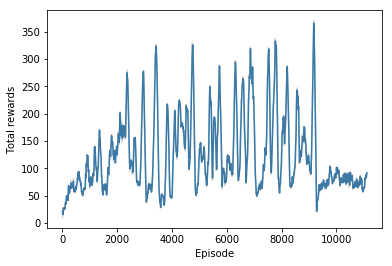

In [90]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

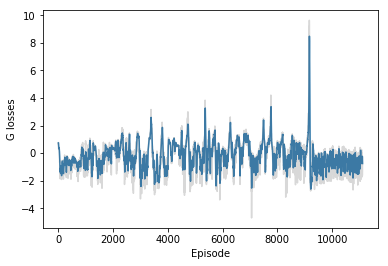

In [91]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

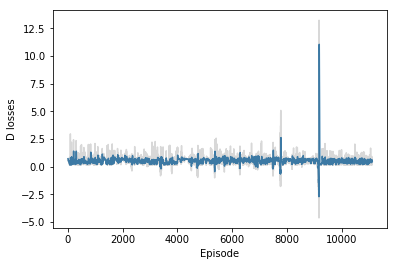

In [92]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.